# Hyperparameters

## Visual Python Upgrade
NOTE: 
- Refresh your web browser to start a new version.
- Save VP Note before refreshing the page.

**Libraries**

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams.update({'figure.figsize': (10, 10), 'figure.dpi': 50, 'font.size': 10})
plt.style.use('fivethirtyeight')
#plt.rcParams['font.size'] = 10
clock_0 =time.time()

In [2]:
print( "Pandas", pd.__version__)
print("Numpy", np.__version__)
#print(plt.__version__)
print("Seaborn",sns.__version__)

Pandas 1.3.5
Numpy 1.21.2
Seaborn 0.11.2


*    Constants and variables

In [3]:
clock_0 =time.time()
TEST_SIZE = 0.3
RANDOM_STATE = 42
modelado = [] # resultados

## Get data

In [4]:
#tarjeta = pd.read_csv("~/Trabajo_tfm/datos_csv/tarjeta_datos0.csv", index_col='Unnamed: 0') # iter 0
tarjeta = pd.read_csv("~/Trabajo_tfm/datos_csv/tarjeta_datos_1.csv")
                      #index_col='Unnamed: 0') # iter 0
tarjeta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7077 entries, 0 to 7076
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fecha              7077 non-null   object 
 1   provincia          7077 non-null   object 
 2   v_muy_cortos       7077 non-null   float64
 3   v_cortos           7077 non-null   float64
 4   v_medios           7077 non-null   float64
 5   v_largos           7077 non-null   float64
 6   v_muy_largos       7077 non-null   float64
 7   v_extra_largos     7077 non-null   float64
 8   v_noche            7077 non-null   float64
 9   v_madrugada        7077 non-null   float64
 10  v_mañana           7077 non-null   float64
 11  v_mediodia         7077 non-null   float64
 12  v_sobremesa        7077 non-null   float64
 13  v_tarde            7077 non-null   float64
 14  v_km_muy_cortos    7077 non-null   float64
 15  v_km_cortos        7077 non-null   float64
 16  v_km_medios        7077 

In [5]:
#data = pd.get_dummies(tarjeta)
X = tarjeta.drop(columns=['num_casos']).select_dtypes(exclude=['object'])
Y = tarjeta[['num_casos']]

In [6]:
features = X.columns.tolist()
labels = Y.num_casos

In [7]:
lista_variables = list(X.columns)
lista_variables

['v_muy_cortos',
 'v_cortos',
 'v_medios',
 'v_largos',
 'v_muy_largos',
 'v_extra_largos',
 'v_noche',
 'v_madrugada',
 'v_mañana',
 'v_mediodia',
 'v_sobremesa',
 'v_tarde',
 'v_km_muy_cortos',
 'v_km_cortos',
 'v_km_medios',
 'v_km_largos',
 'v_km_muy_largos',
 'v_km_extra_largos',
 'v_km_noche',
 'v_km_madrugada',
 'v_km_mañana',
 'v_km_mediodia',
 'v_km_sobremesa',
 'v_km_tarde',
 'cero_viajes',
 'un_viaje',
 'dos_viajes',
 'mas_de_dos_viajes',
 'altitud',
 'velmedia',
 'tmin',
 'tmed',
 'tmax',
 'presMin',
 'presMax',
 'sol',
 'prec',
 'ha',
 'psat',
 'hr',
 'vol_min',
 'vol_max',
 'delta_V',
 'delta_P',
 'delta_T',
 'poblacion']

## Normalización.

In [8]:
from sklearn import preprocessing # RobustScaler() # StandardScaler() MinMaxScaler
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
X_norm = scaler.fit_transform(X)

In [9]:
X_norm

array([[ 0.34600884,  0.67964668,  0.58261285, ...,  0.30032401,
        -0.20018605,  0.48710119],
       [-0.48108059, -0.42780829, -0.57952245, ..., -0.60139513,
        -0.70008609, -0.3451965 ],
       [-0.36104634, -0.55559373, -0.52122318, ...,  0.50526017,
        -0.91743393, -0.3767292 ],
       ...,
       [ 0.71218802,  0.70321838,  0.30411476, ..., -0.3144845 ,
        -0.41753389,  1.00202217],
       [-0.78439196, -0.81033194, -0.40268896, ..., -0.51942066,
        -0.30885997, -0.74191994],
       [-0.01355094, -0.09393517, -0.44220934, ...,  0.83315804,
        -0.24365562, -0.16452323]])

## Base model

### Liberias ML

In [10]:
#from sklearn.metrics import make_scorer
#from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.inspection import permutation_importance

import xgboost as xgb
print(xgb.__version__)

1.1.1


In [11]:
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, TimeSeriesSplit, StratifiedKFold

from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile

from feature_engine.selection import SmartCorrelatedSelection, DropCorrelatedFeatures
from feature_engine.selection import RecursiveFeatureAddition, RecursiveFeatureElimination, SelectByShuffling

### Funciones auxiliares

In [12]:
def modelo(atributos, labels, feat_eng="base",features = False, graficas= False):
    """ Function to test data (atributos and labels) with four models .
        Optionally (graficas) can show feature's importance an permutation importance.
    """
    num_feats = atributos.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(
        atributos, labels, test_size = TEST_SIZE, random_state = RANDOM_STATE)
    
    reg1 = RandomForestRegressor(random_state=RANDOM_STATE)
    reg2 = xgb.XGBRegressor(random_state = RANDOM_STATE)
    reg3 = GradientBoostingRegressor(random_state = RANDOM_STATE)
    #####################################################################
    # 
    #####################################################################
    reg4 = AdaBoostRegressor(      
        RandomForestRegressor(random_state=RANDOM_STATE))
        #xgb.XGBRegressor(random_state = RANDOM_STATE), random_state = RANDOM_STATE)

    reg1.fit(X_train, y_train)
    reg2.fit(X_train, y_train)
    reg3.fit(X_train, y_train)
    reg4.fit(X_train, y_train)
    
    pred1 = reg1.predict(X_test)
    pred2 = reg2.predict(X_test)
    pred3 = reg3.predict(X_test)
    pred4 = reg4.predict(X_test)
    
    mae1 = mean_absolute_error(y_test, pred1)
    mae2 = mean_absolute_error(y_test, pred2)
    mae3 = mean_absolute_error(y_test, pred3)
    mae4 = mean_absolute_error(y_test, pred4)
    
    media_casos_reales = np.mean(y_test)
    mape1 = mae1/media_casos_reales*100
    mape2 = mae2/media_casos_reales*100
    mape3 = mae3/media_casos_reales*100
    mape4 = mae4/media_casos_reales*100

    mse1 = np.sqrt(mean_squared_error(y_test, pred1))
    mse2 = np.sqrt(mean_squared_error(y_test, pred2))
    mse3 = np.sqrt(mean_squared_error(y_test, pred3))
    mse4 = np.sqrt(mean_squared_error(y_test, pred4))

    r2_score1 = r2_score(y_test, pred1)
    r2_score2 = r2_score(y_test, pred2)
    r2_score3 = r2_score(y_test, pred3)
    r2_score4 = r2_score(y_test, pred4)

    r2_train_1 = reg1.score(X_train, y_train)
    r2_train_2 = reg2.score(X_train, y_train)
    r2_train_3 = reg3.score(X_train, y_train)
    r2_train_4 = reg4.score(X_train, y_train)
    
    modelado.append([feat_eng, 'RandomForest', #reg1.get_params(),
                     num_feats,  r2_score1, mse1, mae1,mape1])
    modelado.append([feat_eng, 'Xgboost',  #reg2.get_params(),
                     num_feats, r2_score2, mse2, mae2, mape2])
    modelado.append([feat_eng, 'GradBoost', #reg3.get_params(), 
                     num_feats, r2_score3, mse3, mae3, mape3])
    modelado.append([feat_eng,'Adaboost',  #reg4.get_params(), 
                     num_feats,  r2_score4, mse4, mae4, mape4])

    columnas = ['mae', 'mape', 'rmse', 'r2',  'train_r2']
    metricas_modelos = pd.DataFrame(
        {'metricas': columnas,
         'RandomForest': [mae1, mape1, mse1, r2_score1,  r2_train_1],
         'Xgboost': [mae2, mape2, mse2, r2_score2, r2_train_2],
         'GradBoost': [mae3, mape3,  mse3, r2_score3,  r2_train_3],
         'Adaboost': [mae4, mape4, mse4, r2_score4,  r2_train_4]})
 
    if graficas :
        
        importancias = pd.DataFrame(
            {
             'Attributes': features ,
             'RandomForest': reg1.feature_importances_,
             'Xgboost' : reg2.feature_importances_,
             'GradBoost': reg3.feature_importances_,
             'Adaboost' : reg4.feature_importances_ })
        
        result1 = permutation_importance(reg1, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=2)
        result2 = permutation_importance(reg2, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=2)
        result3 = permutation_importance(reg3, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=2)
        result4 = permutation_importance(reg4, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=2)

        permutaciones = [result1, result2, result3, result4]
        graficas_importancia(importancias, permutaciones, [pred1, pred2, pred3, pred4])
        
    return metricas_modelos

In [13]:
metricas = modelo(X_norm, labels)
metricas

,metricas,RandomForest,Xgboost,GradBoost,Adaboost
0,mae,98.251149,96.504552,131.593291,102.270315
1,mape,45.491006,44.682318,60.928663,47.351910
2,rmse,248.293930,245.455130,288.327576,227.634102
3,r2,0.822450,0.826487,0.760580,0.850768
4,train_r2,0.973963,0.997393,0.890771,0.996256


In [14]:
kfcv = KFold(n_splits = 5, shuffle = True, random_state=RANDOM_STATE) 
rkfcv = RepeatedKFold(n_splits = 5, n_repeats=2, random_state=RANDOM_STATE)
mae_scoring = { "mae" : make_scorer(mean_absolute_error)} #param_learning_rate

### XGBoost Selected features 

#### SelectKBest : select_kb_xgb

In [15]:
maes = []
for num_feats in range(X_norm.shape[1], 10,  -1):

    select = SelectKBest(score_func = mutual_info_regression, k = num_feats)
    X_best = select.fit_transform(X_norm, Y.num_casos)
    
    X_train, X_test, y_train, y_test = train_test_split(X_best, Y.num_casos, test_size = TEST_SIZE, random_state = RANDOM_STATE)   

    reg = xgb.XGBRegressor(objective = 'reg:squarederror',random_state = RANDOM_STATE) 
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    r2 = r2_score(y_test,pred)
    mae = mean_absolute_error(y_test, pred)
    mse = np.sqrt(mean_squared_error(y_test, pred))
    media_casos_reales = np.mean(y_test)
    mape = mae/media_casos_reales*100

    maes.append([num_feats, r2, mse, mae, mape])

output = pd.DataFrame(maes, columns = ['num_feats','r2_score','rmse','MAE', 'MAPE'])
best_num_feats = output.at[np.argmin(output.MAE),'num_feats']
print(output.at[np.argmin(output.MAE),'MAE'])
print(best_num_feats)

modelado.append(['SelectKBest', 'XGBRegressor',
                 #Xt_selP_ada.get_params(), 
                 output.at[np.argmin(output.MAE),'num_feats'],
                 output.at[np.argmin(output.MAE),'r2_score'],
                 output.at[np.argmin(output.MAE),'rmse'],
                 output.at[np.argmin(output.MAE),'MAE'],
                 output.at[np.argmin(output.MAE),'MAPE']
                ])

select_kb_xgb = SelectKBest(score_func = mutual_info_regression, k = best_num_feats)

Xt_selK_xgb = select_kb_xgb.fit_transform(X_norm, Y.num_casos)

90.46586796408431
30


In [16]:
Xt_selK_xgb.shape

(7077, 30)

#### SelectPercentile : Xt_selP_xgb

In [17]:
maes = []
for percentiles in range(99, 84,  -1):

    selected_top_columns = SelectPercentile(mutual_info_regression, percentile=percentiles)

    X_best_perc = selected_top_columns.fit_transform(X_norm, Y.num_casos)
    X_train, X_test, y_train, y_test = train_test_split(X_best_perc, Y.num_casos, test_size = TEST_SIZE,
                                                        random_state = RANDOM_STATE)                                
    
    reg = xgb.XGBRegressor( objective = 'reg:squarederror',random_state = RANDOM_STATE) 
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, pred)
    mse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test,pred)
    media_casos_reales = np.mean(y_test)
    mape = 100 * mae/np.mean(y_test)

    maes.append([percentiles, r2, mse, mae, mape])

output = pd.DataFrame(maes, columns = ['num_feats','r2_score','rmse','MAE', 'MAPE'])
print(output.at[np.argmin(output.MAE),'MAE'])
best_percentiles = output.at[np.argmin(output.MAE),'num_feats'] # percentil
print(best_percentiles)

selected_top_columns_xgb = SelectPercentile(mutual_info_regression, percentile = best_percentiles)

Xt_selP_xgb = selected_top_columns_xgb.fit_transform(X_norm, Y.num_casos)

modelado.append(['SelectPercentile', 'XGBRegressor',
                 #Xt_selP_ada.get_params(), 
                 Xt_selP_xgb.shape[1], # output.at[np.argmin(output.MAE),'num_feats'],
                 output.at[np.argmin(output.MAE),'r2_score'],
                 output.at[np.argmin(output.MAE),'rmse'],
                 output.at[np.argmin(output.MAE),'MAE'],
                 output.at[np.argmin(output.MAE),'MAPE']
                ])



93.28123093653197
86


In [18]:
Xt_selP_xgb.shape

(7077, 39)

#### SmartCorrelatedSelection : Xt_scs_xgb

In [19]:
maes = []
for thresholds in np.linspace(start=0.85, stop=0.99, num=14).tolist():

    tr_xgbsmart = SmartCorrelatedSelection(method='spearman', threshold=thresholds,
                                           scoring="neg_mean_absolute_error", selection_method="model_performance",
                                           estimator= xgb.XGBRegressor(random_state=RANDOM_STATE)) 

    X_tr_xgbsmart = tr_xgbsmart.fit_transform(X_norm, Y.num_casos)
    X_train, X_test, y_train, y_test = train_test_split(X_tr_xgbsmart, Y.num_casos,
                                                        test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    reg = xgb.XGBRegressor(random_state=RANDOM_STATE)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, pred)
    mse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test,pred)
    media_casos_reales = np.mean(y_test)
    mape = mae/media_casos_reales*100

    maes.append([thresholds, r2, mse, mae, mape])

output = pd.DataFrame(maes, columns = ['num_feats','r2_score','rmse','MAE', 'MAPE'])

print(output.at[np.argmin(output.MAE),'MAE'])
best_threshold = output.at[np.argmin(output.MAE),'num_feats']# thresholds
print(best_threshold)    

tr_xgbsmart = SmartCorrelatedSelection(method='spearman',
                                       threshold=best_threshold,
                                       scoring="neg_mean_absolute_error", selection_method="model_performance",
                                       estimator= xgb.XGBRegressor(random_state=RANDOM_STATE)) 

Xt_scs_xgb = tr_xgbsmart.fit_transform(X_norm, Y.num_casos)

modelado.append(['SmartCorrelatedSelection', 'XGBRegressor',
                 #Xt_selP_ada.get_params(), 
                 Xt_scs_xgb.shape[1],
                 output.at[np.argmin(output.MAE),'r2_score'],
                 output.at[np.argmin(output.MAE),'rmse'],
                 output.at[np.argmin(output.MAE),'MAE'],
                 output.at[np.argmin(output.MAE),'MAPE']
                ])

96.71451400247054
0.99


#### DropCorrelatedFeatures : Xt_dcf_xgb

In [20]:
start = time.time()
maes = []
for thresholds in np.linspace(start=0.85, stop=0.99, num=14).tolist():

    trh_dcf = DropCorrelatedFeatures(variables=None, method='spearman',
                                     threshold=thresholds)
    X_best_dcf = trh_dcf.fit_transform(X_norm, Y.num_casos)
    X_train, X_test, y_train, y_test = train_test_split(X_best_dcf, Y.num_casos,
                                                        test_size = TEST_SIZE,
                                                        random_state = RANDOM_STATE)                                
    
    reg = xgb.XGBRegressor( objective = 'reg:squarederror',random_state = RANDOM_STATE) 
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, pred)
    mse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test,pred)
    media_casos_reales = np.mean(y_test)
    mape = mae/media_casos_reales*100

    maes.append([thresholds, r2, mse, mae, mape])

output = pd.DataFrame(maes, columns = ['num_feats','r2_score','rmse','MAE', 'MAPE'])

print(output.at[np.argmin(output.MAE),'MAE'])
best_threshold = output.at[np.argmin(output.MAE),'num_feats']
print(best_threshold)    
print("DropCorrelatedFeatures took %.2f seconds for Xt_dcf_xgb  ." % ((time.time() - start)))

tr_dcf = DropCorrelatedFeatures(variables=None, method='spearman', threshold=best_threshold)

Xt_dcf_xgb = tr_dcf.fit_transform(X_norm, Y.num_casos)

modelado.append(['DropCorrelatedFeatures', 'XGBRegressor',
                 #Xt_selP_ada.get_params(), 
                 Xt_dcf_xgb.shape[1],
                 output.at[np.argmin(output.MAE),'r2_score'],
                 output.at[np.argmin(output.MAE),'rmse'],
                 output.at[np.argmin(output.MAE),'MAE'],
                 output.at[np.argmin(output.MAE),'MAPE']
                ])
print ('Dim: ', Xt_dcf_xgb.shape[1],' | ', 'r2: ',output.at[np.argmin(output.MAE),'r2_score'],' | ',
       'MSE: ',output.at[np.argmin(output.MAE),'rmse'], ' | ', 
       'MAE: ',output.at[np.argmin(output.MAE),'MAE'])

95.61838465068918
0.8715384615384615
DropCorrelatedFeatures took 3.92 seconds for Xt_dcf_xgb  .
Dim:  21  |  r2:  0.8845905589694082  |  MSE:  200.1826078223588  |  MAE:  95.61838465068918


In [78]:
print("Dimension :", Xt_dcf_xgb.shape[1])
print("Cols :", Xt_dcf_xgb.columns)
lista_Xt_dcf_xgb = Xt_dcf_xgb.columns
[lista_variables[int(x)] for x in lista_Xt_dcf_xgb]

Dimension : 21
Cols : Index(['0', '2', '3', '5', '6', '7', '18', '19', '24', '25', '26', '28', '29',
       '30', '32', '35', '36', '37', '39', '40', '44'],
      dtype='object')


['v_muy_cortos',
 'v_medios',
 'v_largos',
 'v_extra_largos',
 'v_noche',
 'v_madrugada',
 'v_km_noche',
 'v_km_madrugada',
 'cero_viajes',
 'un_viaje',
 'dos_viajes',
 'altitud',
 'velmedia',
 'tmin',
 'tmax',
 'sol',
 'prec',
 'ha',
 'hr',
 'vol_min',
 'delta_T']

#### RecursiveFeatureAddition : Xt_rfa_xgb

In [21]:
start = time.time()

trrec_ad = RecursiveFeatureAddition(estimator=xgb.XGBRegressor(random_state=RANDOM_STATE),
                                    scoring ="neg_mean_absolute_error",
                                    cv=kfcv)

Xt_rfa_xgb = trrec_ad.fit_transform(X_norm, labels)

print("RecursiveFeatureAddition took %.2f seconds for Xt_trrec_ad  ." % ((time.time() - start)))

X_train, X_test, y_train, y_test = train_test_split(Xt_rfa_xgb, labels,
                                                    test_size = TEST_SIZE, random_state = RANDOM_STATE)

reg = xgb.XGBRegressor(random_state = RANDOM_STATE)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mape = mae / np.mean(y_test)*100
mse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
r2_train_ = reg.score(X_train, y_train)

print (Xt_rfa_xgb.shape[1], r2_score, mse, mae)

modelado.append(['RecursiveFeatureAddition', 'XGBRegressor',
                 #reg.get_params(),
                 Xt_rfa_xgb.shape[1],
                 r2, mse, mae, mape
                ])

print ( 'Dim: ', Xt_rfa_xgb.shape[1],' | ', 'r2: ',r2,' | ', 'MSE: ',mse, ' | ', 'MAE: ',mae)

RecursiveFeatureAddition took 38.25 seconds for Xt_trrec_ad  .
15 <function r2_score at 0x7feffbb705e0> 212.9090160033707 92.59794986817684
Dim:  15  |  r2:  0.8694500355316364  |  MSE:  212.9090160033707  |  MAE:  92.59794986817684


In [22]:
print("Dimension :", Xt_rfa_xgb.shape[1])
print("Cols :", Xt_rfa_xgb.columns)
lista_Xt_rfa_xgb = Xt_rfa_xgb.columns
[lista_variables[int(x)] for x in lista_Xt_rfa_xgb]

Dimension : 15
Cols : Index(['4', '7', '8', '9', '10', '11', '13', '18', '19', '21', '23', '30',
       '39', '40', '45'],
      dtype='object')


['v_muy_largos',
 'v_madrugada',
 'v_mañana',
 'v_mediodia',
 'v_sobremesa',
 'v_tarde',
 'v_km_cortos',
 'v_km_noche',
 'v_km_madrugada',
 'v_km_mediodia',
 'v_km_tarde',
 'tmin',
 'hr',
 'vol_min',
 'poblacion']

#### RecursiveFeatureElimination : Xt_rfe_xgb

In [23]:
start = time.time()

trrec = RecursiveFeatureElimination(estimator=xgb.XGBRegressor(random_state=RANDOM_STATE),
                                    scoring="neg_mean_absolute_error",
                                    cv=kfcv)

Xt_rfe_xgb = trrec.fit_transform(X_norm, labels)
print("RecursiveFeatureElimination took %.2f seconds for Xt_rfe_xgb  ." % ((time.time() - start)))

X_train, X_test, y_train, y_test = train_test_split(Xt_rfe_xgb, labels, test_size = TEST_SIZE, random_state = RANDOM_STATE)

reg = xgb.XGBRegressor(random_state = RANDOM_STATE)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mape = mae / np.mean(y_test)*100
mse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
r2_train_ = reg.score(X_train, y_train)

print ( 'Dim: ', Xt_rfe_xgb.shape[1],' | ', 'r2: ',r2,' | ', 'MSE: ',mse, ' | ', 'MAE: ',mae)

modelado.append(['RecursiveFeatureElimination', 'XGBRegressor', #reg.get_params(),
                 Xt_rfe_xgb.shape[1], r2, mse, mae, mape
                ])

RecursiveFeatureElimination took 85.60 seconds for Xt_rfe_xgb  .
Dim:  40  |  r2:  0.8286830186689667  |  MSE:  243.89667544471575  |  MAE:  99.33538026442636


In [24]:
# print the selected features


In [84]:
selected_features = lista_variables[Xt_rfe_xgb.support_]
print(selected_features)

AttributeError: 'DataFrame' object has no attribute 'support_'

In [76]:
print("Dimension :", Xt_rfe_xgb.shape)
print("Cols :", Xt_rfe_xgb.columns)
lista_Xt_rfe_xgb = Xt_rfe_xgb.columns
[lista_variables[int(x)] for x in lista_Xt_rfe_xgb]

Dimension : (7077, 40)
Cols : Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '30', '31', '32', '33', '35', '36', '37', '39', '40',
       '41', '43', '44'],
      dtype='object')


['v_muy_cortos',
 'v_cortos',
 'v_medios',
 'v_largos',
 'v_muy_largos',
 'v_extra_largos',
 'v_noche',
 'v_madrugada',
 'v_mañana',
 'v_mediodia',
 'v_sobremesa',
 'v_tarde',
 'v_km_muy_cortos',
 'v_km_cortos',
 'v_km_medios',
 'v_km_largos',
 'v_km_muy_largos',
 'v_km_noche',
 'v_km_madrugada',
 'v_km_mañana',
 'v_km_mediodia',
 'v_km_sobremesa',
 'v_km_tarde',
 'cero_viajes',
 'un_viaje',
 'dos_viajes',
 'mas_de_dos_viajes',
 'altitud',
 'tmin',
 'tmed',
 'tmax',
 'presMin',
 'sol',
 'prec',
 'ha',
 'hr',
 'vol_min',
 'vol_max',
 'delta_P',
 'delta_T']

### ADaBoost(XGboost) Selected features

#### SelectKBest : Xt_selK_ada

In [25]:
start = time.time()
maes = []
for num_feats in range(X_norm.shape[1], 10,  -1):

    select = SelectKBest(score_func = mutual_info_regression, k = num_feats)
    X_best = select.fit_transform(X_norm, Y.num_casos)
    
    X_train, X_test, y_train, y_test = train_test_split(X_best, Y.num_casos, test_size = TEST_SIZE, random_state = RANDOM_STATE)   
    
    reg = AdaBoostRegressor(xgb.XGBRegressor(random_state=RANDOM_STATE), random_state=RANDOM_STATE)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    r2 = r2_score(y_test,pred)
    mae = mean_absolute_error(y_test, pred)
    mse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mae / np.mean(y_test)*100

    maes.append([num_feats, r2, mse, mae, mape])

output = pd.DataFrame(maes, columns = ['num_feats','r2_score','rmse','MAE', 'MAPE'])
bestK_ada = output.at[np.argmin(output.MAE),'num_feats']

select_kb_ada = SelectKBest(score_func = mutual_info_regression, k = bestK_ada)
Xt_selK_ada = select_kb_ada.fit_transform(X_norm, Y.num_casos)

print(output.at[np.argmin(output.MAE),'MAE'])
print("SelectKBest took %.2f seconds for Xt_selK_ada  ." % ((time.time() - start)))

modelado.append(['SelectKBest', 'AdaBoost(xgb)',  #Xt_selP_ada.get_params(),
                 bestK_ada, #Xt_selK_ada.shape[1], 
                 output.at[np.argmin(output.MAE),'r2_score'],
                 output.at[np.argmin(output.MAE),'rmse'],
                 output.at[np.argmin(output.MAE),'MAE'],
                 output.at[np.argmin(output.MAE),'MAPE']
                ])

86.97394054397071
SelectKBest took 367.12 seconds for Xt_selK_ada  .


In [102]:
select_kb_ada.get_feature_names_out(). # mask feaures names

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x19', 'x20', 'x21', 'x23', 'x24',
       'x26', 'x27', 'x28', 'x31', 'x35', 'x38', 'x39', 'x45'],
      dtype=object)

In [112]:
select_kb_ada.get_support(indices= True)# mask feaures names

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 19, 20,
       21, 23, 24, 26, 27, 28, 31, 35, 38, 39, 45])

In [ ]:
print("Cols :", Xt_scs_xgb.columns)


In [113]:
print("Dimension :", Xt_selK_ada.shape[1])
lista_Xt_kb_ada = select_kb_ada.get_support(indices= True)
print("Cols :", lista_Xt_kb_ada)
[lista_variables[int(x)] for x in lista_Xt_kb_ada]

#print("Dimension :", Xt_selK_ada.shape)
#lista_Xt_selK_ada = Xt_selK_ada.columns


Dimension : 28
Cols : [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 19 20 21 23 24 26 27 28 31
 35 38 39 45]


['v_muy_cortos',
 'v_cortos',
 'v_medios',
 'v_largos',
 'v_muy_largos',
 'v_noche',
 'v_madrugada',
 'v_mañana',
 'v_mediodia',
 'v_sobremesa',
 'v_tarde',
 'v_km_muy_cortos',
 'v_km_cortos',
 'v_km_medios',
 'v_km_largos',
 'v_km_madrugada',
 'v_km_mañana',
 'v_km_mediodia',
 'v_km_tarde',
 'cero_viajes',
 'dos_viajes',
 'mas_de_dos_viajes',
 'altitud',
 'tmed',
 'sol',
 'psat',
 'hr',
 'poblacion']

#### SelectPercentile : Xt_selP_ada 

In [27]:
start = time.time()
maes = []
for percentiles in range(99, 84,  -1):

    selected_top_columns = SelectPercentile(mutual_info_regression, percentile=percentiles)

    X_best_perc = selected_top_columns.fit_transform(X_norm, Y.num_casos)
    X_train, X_test, y_train, y_test = train_test_split(X_best_perc, Y.num_casos, test_size = TEST_SIZE,
                                                        random_state = RANDOM_STATE)                                
    
    reg = AdaBoostRegressor(xgb.XGBRegressor(random_state=RANDOM_STATE), random_state=RANDOM_STATE) 
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    r2 = r2_score(y_test,pred)
    mae = mean_absolute_error(y_test, pred)
    mse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mae / np.mean(y_test)*100
  
    maes.append([percentiles, r2, mse, mae, mape])

output = pd.DataFrame(maes, columns = ['num_feats','r2_score','rmse','MAE','MAPE']) 
bestP_ada = output.at[np.argmin(output.MAE),'num_feats']
print(output.at[np.argmin(output.MAE),'MAE'])
print("SelectPercentile took %.2f seconds for Xt_selP_ada  ." % ((time.time() - start)))

selected_top_columns_ada = SelectPercentile(mutual_info_regression, percentile = bestP_ada)

Xt_selP_ada = selected_top_columns_ada.fit_transform(X_norm, Y.num_casos)
print ('Dim: ', Xt_selP_ada.shape[1],' | ',
       'r2: ',output.at[np.argmin(output.MAE),'r2_score'],' | ',
       'MSE: ',output.at[np.argmin(output.MAE),'rmse'], ' | ',
       'MAE: ',output.at[np.argmin(output.MAE),'MAE'])

modelado.append(['SelectPercentile', 'AdaBoost(xgbr)',  #Xt_selP_ada.get_params(), 
                 Xt_selP_ada.shape[1],
                 output.at[np.argmin(output.MAE),'r2_score'],
                 output.at[np.argmin(output.MAE),'rmse'],
                 output.at[np.argmin(output.MAE),'MAE'],
                 output.at[np.argmin(output.MAE),'MAPE']
                ])

87.98951805067264
SelectPercentile took 196.13 seconds for Xt_selP_ada  .
Dim:  39  |  r2:  0.8846442706443772  |  MSE:  200.13601980332123  |  MAE:  87.98951805067264


#### SmartCorrelatedSelection : Xt_scs_ada

In [28]:
start = time.time()
maes = []
for thresholds in np.linspace(start=0.85, stop=0.99, num=14).tolist():

    tr_xgbsmart = SmartCorrelatedSelection(method='spearman', threshold=thresholds,
                                           scoring="neg_mean_absolute_error", selection_method="model_performance",
                                           estimator= xgb.XGBRegressor(random_state=RANDOM_STATE)) 

    X_tr_xgbsmart = tr_xgbsmart.fit_transform(X_norm, Y.num_casos)
    X_train, X_test, y_train, y_test = train_test_split(X_tr_xgbsmart, Y.num_casos,
                                                        test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    reg = AdaBoostRegressor(xgb.XGBRegressor(random_state=RANDOM_STATE), random_state=RANDOM_STATE)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    r2 = r2_score(y_test,pred)
    mae = mean_absolute_error(y_test, pred)
    mse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mae / np.mean(y_test)*100
    
    maes.append([thresholds, r2, mse, mae, mape])


print("SmartCorrelatedSelection took %.2f seconds for Xt_scs_ada  ." % ((time.time() - start)))

output = pd.DataFrame(maes, columns=['num_feats','r2_score','rmse','MAE', 'MAPE'])
print(output.at[np.argmin(output.MAE),'MAE'])
print(output.at[np.argmin(output.MAE),'num_feats'])

best_thrsh_ada = output.at[np.argmin(output.MAE),'num_feats']

tr_xgbsmart = SmartCorrelatedSelection(method='spearman', 
                                       threshold=best_thrsh_ada,
                                       scoring="neg_mean_absolute_error",
                                       selection_method="model_performance",
                                       estimator= xgb.XGBRegressor(random_state=RANDOM_STATE)) 

Xt_scs_ada = tr_xgbsmart.fit_transform(X_norm, Y.num_casos)

print ('Dim: ', Xt_scs_ada.shape[1],' | ',
       'r2: ',output.at[np.argmin(output.MAE),'r2_score'],' | ',
       'MSE: ',output.at[np.argmin(output.MAE),'rmse'], ' | ',
       'MAE: ',output.at[np.argmin(output.MAE),'MAE'])

modelado.append(['SmartCorrelatedSelection', 'AdaBoost(xgbr)',#   Xt_scs_ada.get_params(), 
                 Xt_scs_ada.shape[1],
                 output.at[np.argmin(output.MAE),'r2_score'],
                 output.at[np.argmin(output.MAE),'rmse'],
                 output.at[np.argmin(output.MAE),'MAE'],
                 output.at[np.argmin(output.MAE),'MAPE']
                ])

SmartCorrelatedSelection took 232.60 seconds for Xt_scs_ada  .
91.90650983206689
0.9684615384615385
Dim:  31  |  r2:  0.8723158072297377  |  MSE:  210.55920946482217  |  MAE:  91.90650983206689


#### DropCorrelatedFeatures : Xt_dcf_ada

In [29]:
start = time.time()
maes = []
for thresholds in np.linspace(start=0.85, stop=0.99, num=14).tolist():

    trh_dcf = DropCorrelatedFeatures(variables=None, method='spearman', threshold=thresholds)
    X_best_dcf = trh_dcf.fit_transform(X_norm, Y.num_casos)
    X_train, X_test, y_train, y_test = train_test_split(X_best_dcf, Y.num_casos,
                                                        test_size = TEST_SIZE,
                                                        random_state = RANDOM_STATE)                                
    
    reg = AdaBoostRegressor(xgb.XGBRegressor(random_state=RANDOM_STATE), random_state=RANDOM_STATE)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)

    r2 = r2_score(y_test,pred)
    mae = mean_absolute_error(y_test, pred)
    mse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mae / np.mean(y_test)*100
    
    maes.append([thresholds, r2, mse, mae, mape])

print("DropCorrelatedFeatures took %.2f seconds for Xt_dcf_ada  ." % ((time.time() - start)))

output = pd.DataFrame(maes, columns =  ['num_feats','r2_score','rmse','MAE', 'MAPE']) 
print(output.at[np.argmin(output.MAE),'MAE'])
print(output.at[np.argmin(output.MAE),'num_feats'])

best_dc_thrsh_ada = output.at[np.argmin(output.MAE),'num_feats']

tr_dcf = DropCorrelatedFeatures(variables=None, method='spearman', threshold = best_dc_thrsh_ada)
Xt_dcf_ada = tr_dcf.fit_transform(X_norm, Y.num_casos)

print ('Dim: ', Xt_dcf_ada.shape[1],' | ',
       'r2: ',output.at[np.argmin(output.MAE),'r2_score'],' | ',
       'MSE: ',output.at[np.argmin(output.MAE),'rmse'], ' | ',
       'MAE: ',output.at[np.argmin(output.MAE),'MAE'])

modelado.append(['DropCorrelatedFeatures', 'AdaBoost(xgbr)',  #Xt_dcf_ada.get_params(), 
                 Xt_dcf_ada.shape[1],
                 output.at[np.argmin(output.MAE),'r2_score'],
                 output.at[np.argmin(output.MAE),'rmse'],
                 output.at[np.argmin(output.MAE),'MAE'],
                 output.at[np.argmin(output.MAE),'MAPE']
                ])

DropCorrelatedFeatures took 119.29 seconds for Xt_dcf_ada  .
92.25280192657155
0.9253846153846154
Dim:  26  |  r2:  0.8755445976350698  |  MSE:  207.8799244996382  |  MAE:  92.25280192657155


#### RecursiveFeatureAddition : Xt_rfa_ada

In [30]:
start = time.time() # 1729.74 seconds

trrec_ada = RecursiveFeatureAddition(
    estimator = AdaBoostRegressor(
        xgb.XGBRegressor(random_state=RANDOM_STATE), random_state=RANDOM_STATE),
    scoring ="neg_mean_absolute_error", 
    cv = kfcv)

Xt_rfa_ada = trrec_ada.fit_transform(X_norm, Y.num_casos)

print("RecursiveFeatureAddition took %.2f seconds for Xt_rfa_ada  ." % ((time.time() - start)))

RecursiveFeatureAddition took 2248.55 seconds for Xt_rfa_ada  .


In [31]:
X_train, X_test, y_train, y_test = train_test_split(Xt_rfa_ada, labels,
                                                    test_size = TEST_SIZE, random_state = RANDOM_STATE)

ada_xgb_rfa = AdaBoostRegressor(
    xgb.XGBRegressor(random_state=RANDOM_STATE), random_state=RANDOM_STATE)

ada_xgb_rfa.fit(X_train, y_train)
pred = ada_xgb_rfa.predict(X_test)

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = np.sqrt(mean_squared_error(y_test, pred))
mape =100 *  mae / np.mean(y_test)

print (Xt_rfa_ada.shape[1], r2 , mse , mae, mape )

modelado.append(['RecursiveFeatureAddition', 'AdaBoost(xgbr)', 
                 #reg3.get_params(), 
                 Xt_rfa_ada.shape[1], r2, mse, mae, mape])

20 0.893301679615822 192.4794926574285 87.22467872604251 40.38566892229025


In [32]:
print("Dimension :", Xt_rfa_ada.shape)
print("Cols :", Xt_rfa_ada.columns)
lista = Xt_rfa_ada.columns
[lista_variables[int(x)] for x in lista]

Dimension : (7077, 20)
Cols : Index(['2', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '19', '21',
       '22', '23', '24', '27', '39', '40', '45'],
      dtype='object')


['v_medios',
 'v_noche',
 'v_madrugada',
 'v_mañana',
 'v_mediodia',
 'v_sobremesa',
 'v_tarde',
 'v_km_muy_cortos',
 'v_km_cortos',
 'v_km_largos',
 'v_km_muy_largos',
 'v_km_madrugada',
 'v_km_mediodia',
 'v_km_sobremesa',
 'v_km_tarde',
 'cero_viajes',
 'mas_de_dos_viajes',
 'hr',
 'vol_min',
 'poblacion']


#### RecursiveFeatureElimination : Xt_rfe_ada

In [33]:
start = time.time()

trrfe = RecursiveFeatureElimination(
    estimator = AdaBoostRegressor(
        xgb.XGBRegressor(random_state=RANDOM_STATE),random_state=RANDOM_STATE),
    scoring = "neg_mean_absolute_error", 
    cv = kfcv)

Xt_rfe_ada = trrfe.fit_transform(X_norm, Y.num_casos)

print("RecursiveFeatureElimination took %.2f seconds for Xt_rfe_ada  ." % ((time.time() - start)))

RecursiveFeatureElimination took 4116.15 seconds for Xt_rfe_ada  .


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    Xt_rfe_ada, Y.num_casos, test_size = TEST_SIZE, random_state = RANDOM_STATE)

ada_xgb_rfe = AdaBoostRegressor(xgb.XGBRegressor(random_state=RANDOM_STATE),
                                random_state=RANDOM_STATE)

ada_xgb_rfe.fit(X_train, y_train)
pred = ada_xgb_rfe.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mape = mae / np.mean(y_test)*100
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
#r2_train_4 = ada_xgb_rfe.score(X_train, y_train)

print ( 'Dim: ', Xt_rfe_ada.shape[1],' | ', 'r2: ',r2,' | ', 'MSE: ',rmse, ' | ', 'MAE: ',mae)

modelado.append(['RecursiveFeatureElimination', 'AdaBoost',   #reg4.get_params(),
                 Xt_rfe_ada.shape[1],  r2, mse, mae, mape])

Dim:  38  |  r2:  0.8761173130020747  |  MSE:  207.40106497159985  |  MAE:  90.64349552260785


### Results

In [35]:
columnas = ['Metodo','Modelo', '#Feats', 'r2', 'MSE', 'MAE', 'MAPE']
Resultados_feat_eng = pd.DataFrame(modelado, columns=columnas)

In [36]:
Resultados_feat_eng  

,Metodo,Modelo,#Feats,r2,MSE,MAE,MAPE
0,base,RandomForest,46,0.822450,248.293930,98.251149,45.491006
1,base,Xgboost,46,0.826487,245.455130,96.504552,44.682318
2,base,GradBoost,46,0.760580,288.327576,131.593291,60.928663
3,base,Adaboost,46,0.850768,227.634102,102.270315,47.351910
4,SelectKBest,XGBRegressor,30,0.871019,211.626153,90.465868,41.886363
5,SelectPercentile,XGBRegressor,39,0.839903,235.774695,93.281231,43.189897
6,SmartCorrelatedSelection,XGBRegressor,35,0.829746,243.138502,96.714514,44.779533
7,DropCorrelatedFeatures,XGBRegressor,21,0.884591,200.182608,95.618385,44.272017
8,RecursiveFeatureAddition,XGBRegressor,15,0.869450,212.909016,92.597950,42.873533
9,RecursiveFeatureElimination,XGBRegressor,40,0.828683,243.896675,99.335380,45.993013


In [37]:
gmap = np.array([[1,2], [3,4],  [5,6], [7,8], [9,10],[11,12], [3,4],  [3,4], [1,2], [3,4]
                ,[1,2], [3,4],  [3,4], [1,2], [3,4]])
Resultados_feat_eng.head(15).style.background_gradient(
    axis=None, gmap=gmap, cmap='gist_rainbow',
    subset = ['#Feats','MAE' ])

,Metodo,Modelo,#Feats,r2,MSE,MAE,MAPE
0,base,RandomForest,46,0.822450,248.293930,98.251149,45.491006
1,base,Xgboost,46,0.826487,245.455130,96.504552,44.682318
2,base,GradBoost,46,0.760580,288.327576,131.593291,60.928663
3,base,Adaboost,46,0.850768,227.634102,102.270315,47.351910
4,SelectKBest,XGBRegressor,30,0.871019,211.626153,90.465868,41.886363
5,SelectPercentile,XGBRegressor,39,0.839903,235.774695,93.281231,43.189897
6,SmartCorrelatedSelection,XGBRegressor,35,0.829746,243.138502,96.714514,44.779533
7,DropCorrelatedFeatures,XGBRegressor,21,0.884591,200.182608,95.618385,44.272017
8,RecursiveFeatureAddition,XGBRegressor,15,0.869450,212.909016,92.597950,42.873533
9,RecursiveFeatureElimination,XGBRegressor,40,0.828683,243.896675,99.335380,45.993013


## GridSearch 

In [38]:
from sklearn.model_selection import GridSearchCV
import multiprocessing
mae_scoring = { "mae" : make_scorer(mean_absolute_error)} #param_learning_rate

In [39]:
def mejor_regresor (atributos, regresor, id_reg) :
    
    X_train, X_test, y_train, y_test = train_test_split(atributos, labels,
                                                        test_size = TEST_SIZE, random_state = RANDOM_STATE)
    
    regresor.fit(X_train, y_train)

    results = regresor.cv_results_
    print("best_score_ : ",regresor.best_score_)
    print("best_params_ : ",regresor.best_params_)
    # el mejor modelo
    mejor_modelo = regresor.best_estimator_

    # Entrenamiento del mejor modelo obtenido
    mejor_modelo.fit(X_train, y_train) 

    # nueva predicción 
    prediction = mejor_modelo.predict(X_test)

    #eftEntrenamiento = mejor_modelo.score(X_train, y_train)
    r2 = mejor_modelo.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    mae = mean_absolute_error(y_test, prediction) # np.sqrt(mean_squared_error(y_test, pred))
    mape = mae / np.mean(y_test)*100
    #r2 = r2_score(y_test, prediction)
    modelado.append([id_reg, id_reg, 
                     #mejor_modelo.get_params(),
                     atributos.shape[1],  r2, rmse, mae, mape])
    print("MAE : ",mae)
    print ( 'Dim: ', atributos.shape[1],' | ', 'r2: ',r2,' | ', 'MSE: ',rmse, ' | ', 'MAE: ',mae)

    return mejor_modelo

In [40]:
param_grid =[{#"max_depth" :range(8,16,1), 
              "learning_rate": np.linspace(start=0.2, stop=0.5, num=20).tolist()
             }]

gxb = GridSearchCV(xgb.XGBRegressor(random_state=RANDOM_STATE ),
                   *param_grid,
                   cv=kfcv, 
                   scoring = mae_scoring, #'neg_mean_absolute_error',
                   verbose=1, refit = "mae", return_train_score=True, 
                   n_jobs=multiprocessing.cpu_count() // 2)

### XGBoost

#### SelectKBest

In [41]:
start = time.time() 
best_Grid_Xt_selK_xgb = mejor_regresor(Xt_selK_xgb, gxb, 'best_Grid_Xt_selK_xgb' )
print("best_Grid_Xt_selK_xgb took %.2f seconds for Xt_selK_xgb  ." % ((time.time() - start)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best_score_ :  115.42513139419609
best_params_ :  {'learning_rate': 0.4842105263157895}
MAE :  96.13678447885366
Dim:  30  |  r2:  0.8502940979650357  |  MSE:  227.99490136055886  |  MAE:  96.13678447885366
best_Grid_Xt_selK_xgb took 15.97 seconds for Xt_selK_xgb  .


#### SelectPercentile - 

In [42]:
start = time.time() 
best_Grid_Xt_selP_xgb = mejor_regresor(Xt_selP_xgb, gxb, 'best_Grid_Xt_selP_xgb' )
print("best_Grid_Xt_selP_xgb took %.2f seconds for Xt_selP_xgb  ." % ((time.time() - start)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best_score_ :  114.04567657485738
best_params_ :  {'learning_rate': 0.5}
MAE :  103.00548883534533
Dim:  39  |  r2:  0.828761564822028  |  MSE:  243.84075763152495  |  MAE:  103.00548883534533
best_Grid_Xt_selP_xgb took 18.74 seconds for Xt_selP_xgb  .


#### SmartCorrelatedSelection - 

In [43]:
start = time.time() 
best_Grid_XGB_scs_kfcv = mejor_regresor(Xt_scs_xgb, gxb, 'best_Grid_Xt_scs_xgb' )
print("best_Grid_XGB_scs_kfcv took %.2f seconds for X_best_xcs_xgb  ." % ((time.time() - start)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best_score_ :  119.1735734702512
best_params_ :  {'learning_rate': 0.45263157894736844}
MAE :  106.17011800498163
Dim:  35  |  r2:  0.8122841679003259  |  MSE:  255.30312176826789  |  MAE:  106.17011800498163
best_Grid_XGB_scs_kfcv took 16.04 seconds for X_best_xcs_xgb  .


#### DropCorrelatedFeatures - 

In [44]:
start = time.time() 
best_Grid_XGB_dcf_kfcv = mejor_regresor(Xt_dcf_xgb, gxb, 'best_Grid_Xt_dcf_xgb' )
print("best_Grid_XGB_dcf took %.2f seconds for X_best_dcf_xgb  ." % ((time.time() - start)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best_score_ :  116.42243155862847
best_params_ :  {'learning_rate': 0.4842105263157895}
MAE :  101.95724687403991
Dim:  21  |  r2:  0.8737437320226977  |  MSE:  209.3785306378081  |  MAE:  101.95724687403991
best_Grid_XGB_dcf took 9.86 seconds for X_best_dcf_xgb  .


#### RecursiveFeature addition - 

In [45]:
start = time.time() #  7.94 seconds
best_Grid_XGB_rfa_kfcv = mejor_regresor(Xt_rfa_xgb, gxb, 'best_Grid_Xt_rfa_xgb' )
print("best_Grid_XGB_rfa_kfcv took %.2f seconds for Xt_trrec_ad  ." % ((time.time() - start)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best_score_ :  112.54881478847491
best_params_ :  {'learning_rate': 0.46842105263157896}
MAE :  95.98360587416563
Dim:  15  |  r2:  0.8671501342490815  |  MSE:  214.77623933345313  |  MAE:  95.98360587416563
best_Grid_XGB_rfa_kfcv took 8.81 seconds for Xt_trrec_ad  .


#### RecursiveFeatureElimination - 

In [46]:
start = time.time()  # 15.33 seconds
best_Grid_XGB_rfe_kfcv = mejor_regresor(Xt_rfe_xgb, gxb, 'best_Grid_Xt_rfe_xgb' )
print("best_Grid_XGB_kbest_kfcv took %.2f seconds for X_best_mi  ." % ((time.time() - start)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best_score_ :  116.49761271719706
best_params_ :  {'learning_rate': 0.5}
MAE :  104.11883453438287
Dim:  40  |  r2:  0.8267909904455704  |  MSE:  245.23977723645098  |  MAE:  104.11883453438287
best_Grid_XGB_kbest_kfcv took 19.04 seconds for X_best_mi  .


### AdaBoost(XGBoost)

In [47]:
param_grid_adab= [{
       # "n_estimators" : [50, 100],
        #"loss" : ['linear', 'square', 'exponential'],
        #"learning_rate": np.linspace(start=0.1, stop=7, num=10).tolist()
        "learning_rate": np.linspace(start=0.28, stop=0.5, num=10).tolist()
    }]

gax = GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor(random_state=RANDOM_STATE), random_state=RANDOM_STATE),
                   *param_grid_adab,
                   scoring = 'neg_mean_absolute_error',
                   verbose=1, refit="mae", return_train_score=True, cv=kfcv,
                   n_jobs=multiprocessing.cpu_count() // 2)

#### SelectKBest

In [48]:
start = time.time() # 298.53 seconds
best_Grid_Xt_selK_ada = mejor_regresor(Xt_selK_ada, gax, 'best_Grid_Xt_selK_ada' )
print("best_Grid_Xt_selK_ada took %.2f seconds for Xt_selK_ada  ." % ((time.time() - start)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score_ :  -95.10007300348074
best_params_ :  {'learning_rate': 0.28}
MAE :  84.84158764712218
Dim:  28  |  r2:  0.8881244917688287  |  MSE:  197.09390056066832  |  MAE:  84.84158764712218
best_Grid_Xt_selK_ada took 314.50 seconds for Xt_selK_ada  .


#### SelectPercentile - 

In [49]:
start = time.time() # 384.69 seconds
best_Grid_Xt_selP_ada = mejor_regresor(Xt_selP_ada, gax, 'best_Grid_Xt_selP_ada' )
print("best_Grid_Xt_selP_ada took %.2f seconds for Xt_selP_ada  ." % ((time.time() - start)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score_ :  -96.66111656774899
best_params_ :  {'learning_rate': 0.45111111111111113}
MAE :  85.33627208003777
Dim:  39  |  r2:  0.8915437909260993  |  MSE:  194.05859553588758  |  MAE:  85.33627208003777
best_Grid_Xt_selP_ada took 412.69 seconds for Xt_selP_ada  .


#### SmartCorrelateSelection - 

In [50]:
start = time.time()  # 278
best_grid_ada_scs = mejor_regresor(Xt_scs_ada, gax, 'best_Grid_Xt_scs_ada')
print(
    "GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor took %.2f seconds for X_best_scs_sgb candidates parameter settings."
    % ((time.time() - start))
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score_ :  -98.13690801723257
best_params_ :  {'learning_rate': 0.28}
MAE :  91.38226552793085
Dim:  31  |  r2:  0.8593006139269064  |  MSE:  221.03028059937162  |  MAE:  91.38226552793085
GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor took 305.36 seconds for X_best_scs_sgb candidates parameter settings.


#### DropCorrelatedFeatures - 

In [51]:
start = time.time() # 235.59 seconds
best_grid_ada_dcf = mejor_regresor(Xt_dcf_ada, gax, 'best_Grid_Xt_dcf_ada')
print(
    "GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor took %.2f seconds for X_best_dcf_xgb candidates parameter settings."
    % ((time.time() - start))
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score_ :  -98.95275084043233
best_params_ :  {'learning_rate': 0.30444444444444446}
MAE :  91.45127725873402
Dim:  26  |  r2:  0.8756300120835209  |  MSE:  207.80857767055025  |  MAE:  91.45127725873402
GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor took 268.33 seconds for X_best_dcf_xgb candidates parameter settings.


#### RecursiveFeatureElimination - 

In [52]:
start = time.time() # 336.71
best_grid_ada_rfe = mejor_regresor(Xt_rfe_ada, gax, 'best_Grid_Xt_rfe_ada')
print(
    "GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor took %.2f seconds for rfe  candidates parameter settings."
    % ((time.time() - start))
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score_ :  -97.68013589135955
best_params_ :  {'learning_rate': 0.28}
MAE :  87.20145064061981
Dim:  38  |  r2:  0.8787155394800252  |  MSE:  205.21459941381934  |  MAE:  87.20145064061981
GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor took 380.64 seconds for rfe  candidates parameter settings.


#### RecursiveFeatureAddition - 

In [53]:
start = time.time() # 180.20 
best_grid_ada_rfa = mejor_regresor(Xt_rfa_ada, gax, 'best_Grid_Xt_rfa_ada')
print("GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor took %.2f seconds for RecursiveFeatureAddition candidates parameter settings."
    % ((time.time() - start)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score_ :  -95.84448101788009
best_params_ :  {'learning_rate': 0.3288888888888889}
MAE :  84.73279523828441
Dim:  20  |  r2:  0.8944476603814769  |  MSE:  191.44305051769672  |  MAE:  84.73279523828441
GridSearchCV(AdaBoostRegressor(xgb.XGBRegressor took 251.31 seconds for RecursiveFeatureAddition candidates parameter settings.


In [54]:
metricas_grid = pd.DataFrame(modelado,
                                columns=['Método', 'Modelo',  "#Feats", 'ScoreTest', 'RMSE',  'MAE', 'MAPE'])
nombre = '_t_dat_1.csv'

metricas_grid.to_csv("~/Trabajo_tfm/datos_csv/metricas_grid" + nombre )
metricas_grid.shape

(28, 7)

In [55]:
metricas_grid

,Método,Modelo,#Feats,ScoreTest,RMSE,MAE,MAPE
0,base,RandomForest,46,0.822450,248.293930,98.251149,45.491006
1,base,Xgboost,46,0.826487,245.455130,96.504552,44.682318
2,base,GradBoost,46,0.760580,288.327576,131.593291,60.928663
3,base,Adaboost,46,0.850768,227.634102,102.270315,47.351910
4,SelectKBest,XGBRegressor,30,0.871019,211.626153,90.465868,41.886363
5,SelectPercentile,XGBRegressor,39,0.839903,235.774695,93.281231,43.189897
6,SmartCorrelatedSelection,XGBRegressor,35,0.829746,243.138502,96.714514,44.779533
7,DropCorrelatedFeatures,XGBRegressor,21,0.884591,200.182608,95.618385,44.272017
8,RecursiveFeatureAddition,XGBRegressor,15,0.869450,212.909016,92.597950,42.873533
9,RecursiveFeatureElimination,XGBRegressor,40,0.828683,243.896675,99.335380,45.993013


In [56]:
gmap = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [3, 4],
                 [3, 4], [1, 2], [3, 4], [1, 2], [3, 4], [3, 4], [1, 2],
                 [3, 4]])
metricas_grid.head(15).style.background_gradient(axis=None,
                                               gmap=gmap,
                                               cmap='gist_rainbow',
                                               subset=['#Feats', 'MAE'])

,Método,Modelo,#Feats,ScoreTest,RMSE,MAE,MAPE
0,base,RandomForest,46,0.822450,248.293930,98.251149,45.491006
1,base,Xgboost,46,0.826487,245.455130,96.504552,44.682318
2,base,GradBoost,46,0.760580,288.327576,131.593291,60.928663
3,base,Adaboost,46,0.850768,227.634102,102.270315,47.351910
4,SelectKBest,XGBRegressor,30,0.871019,211.626153,90.465868,41.886363
5,SelectPercentile,XGBRegressor,39,0.839903,235.774695,93.281231,43.189897
6,SmartCorrelatedSelection,XGBRegressor,35,0.829746,243.138502,96.714514,44.779533
7,DropCorrelatedFeatures,XGBRegressor,21,0.884591,200.182608,95.618385,44.272017
8,RecursiveFeatureAddition,XGBRegressor,15,0.869450,212.909016,92.597950,42.873533
9,RecursiveFeatureElimination,XGBRegressor,40,0.828683,243.896675,99.335380,45.993013


## Hiperparámetros XGBoost

In [57]:
# Print Df scores ;: imprime los resultados de de crossval para la metrica mae
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_train_mae, std_train_mae, mean_test_mae, std_test_mae in zip(
        filtered_cv_results["train-mae-mean"],
        filtered_cv_results["train-mae-std"],
        #filtered_cv_results["mean_train_r2"],
        #filtered_cv_results["std_train_r2"],
        filtered_cv_results["test-mae-mean"],
        filtered_cv_results["test-mae-std"],
        #filtered_cv_results["params"],
    ):
        print(
            f"mae test: {mean_test_mae:0.3f} (±{std_test_mae:0.03f}),"
            f" mae train: {mean_train_mae:0.3f} (±{std_train_mae:0.03f}),"
            #f" for {params}"
        )
    print()

In [58]:
def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by mae and keep all models with one standard
    deviation of the best by mae. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_mae = 115

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print("*...*.."*10)

    #print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[cv_results_["test-mae-mean"] < precision_mae]
    
# 'train-mae-mean', 'train-mae-std', 'test-mae-mean', 'test-mae-mean'
    print(f"Models with a precision lower than {precision_mae}:")
    print("*...*.."*10)

    high_precision_cv_results = high_precision_cv_results[
        ['train-mae-mean', 'train-mae-std', 'test-mae-mean', 'test-mae-std']
    ]
    print_dataframe(high_precision_cv_results)

    # Select the most performant models in terms of mae
    # (within 1 sigma from the best)
    best_mae_std = high_precision_cv_results["test-mae-mean"].std()
    best_mae = high_precision_cv_results["test-mae-mean"].max() # max
    best_mae_threshold = best_mae - best_mae_std

    high_mae_cv_results = high_precision_cv_results[
        high_precision_cv_results["test-mae-mean"] < best_mae_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest mae model:"
    )
    print_dataframe(high_mae_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_mae_high_precision_index = high_mae_cv_results[
        "test-mae-mean"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and mae.\n"
        "Its scoring test-mae-mean is:\n\n"
        f"{high_mae_cv_results.loc[fastest_top_mae_high_precision_index]}"
    )

    return fastest_top_mae_high_precision_index

### Interfaz nativa

In [59]:
def xgb_helper(temp_dmatrix, PARAMETERS, V_PARAM_NAME=False, V_PARAM_VALUES=False, BR=50):
  
    if V_PARAM_VALUES == False:
        
        cv_results = xgb.cv(dtrain=temp_dmatrix, nfold=5, num_boost_round=BR,
                            params=PARAMETERS, as_pandas=True, seed=RANDOM_STATE)
        return cv_results

    else:
        results = []

        for v_param_value in V_PARAM_VALUES:
            
            PARAMETERS[V_PARAM_NAME] = v_param_value
            cv_results = xgb.cv(dtrain=temp_dmatrix, nfold=5, num_boost_round=BR,
                                params=PARAMETERS, as_pandas=True, seed=RANDOM_STATE)
            
            results.append(
                (
                    #cv_results["train-mae-mean"].tail().values[-1],
                    cv_results["test-mae-mean"].tail().values[-1]
                )
            )

        data = list(zip(V_PARAM_VALUES, results))
        #print(pd.DataFrame(data, columns=[V_PARAM_NAME, "mae"]))

        return cv_results, pd.DataFrame(data, columns=[V_PARAM_NAME, "mae"])

In [60]:
def params_helper(PARAMETERS, temp_dmatrix, name, values) :
    
    cv_data, results = xgb_helper(temp_dmatrix, PARAMETERS, V_PARAM_NAME= name, 
                                  V_PARAM_VALUES=values)
    ## Ver el menor mae.
    nombre = results.at[np.argmin(results.mae), name]
    print(name +" : ", nombre, results.at[np.argmin(results.mae),'mae'])
    return nombre


In [61]:
def xgb_params (metodo, atributos, etiquetas):
    
    X_train, X_test, y_train, y_test = train_test_split(atributos, etiquetas, 
                                                        test_size = TEST_SIZE, random_state = RANDOM_STATE)
    
    temp_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

    PARAMETERS = {"objective": 'reg:squarederror', "eval_metric": "mae", "random_state": RANDOM_STATE}
    
    
    #PARAMETERS ["learning_rate"] = params_helper(PARAMETERS, temp_dmatrix, "learning_rate",
    #                                             np.linspace(start=0.1, stop=0.4, num=15).tolist())
    
    
    
    PARAMETERS ["min_child_weight"] = params_helper(PARAMETERS, temp_dmatrix, "min_child_weight",
                                                     range(0,5,1))
    
    PARAMETERS ["subsample"] = params_helper(PARAMETERS, temp_dmatrix, "subsample",
                                         np.linspace(start=0.1, stop=.9, num=7).tolist())
    
    PARAMETERS ["colsample_bytree"] = params_helper(PARAMETERS, temp_dmatrix, "colsample_bytree",
                                                    np.linspace(start=0.2, stop=.9, num=6).tolist())
        
    PARAMETERS ["scale_pos_weight"] = params_helper(PARAMETERS, temp_dmatrix, "scale_pos_weight",
                                                    np.linspace(start=0.2, stop=2, num=20).tolist())
    
  
    PARAMETERS ["gamma"] = params_helper(PARAMETERS, temp_dmatrix, "gamma",
                                         np.linspace(start=0.1, stop=4, num=20).tolist()) 
    
    PARAMETERS ["reg_alpha"] = params_helper(PARAMETERS, temp_dmatrix, "reg_alpha",
                                             np.linspace(start=0.001, stop=1, num=20).tolist())
    
    PARAMETERS ["reg_lambda"] = params_helper(PARAMETERS, temp_dmatrix, "reg_lambda",
                                              np.linspace(start=0.001, stop=1, num=20).tolist())
    
    PARAMETERS ["max_depth"] = params_helper(PARAMETERS, temp_dmatrix, "max_depth", range(4, 16, 1))
    
    PARAMETERS ["learning_rate"] = params_helper(PARAMETERS, temp_dmatrix, "learning_rate",
                                                  np.linspace(start=0.1, stop=0.3, num=30).tolist())
    
    xgbr = xgb.XGBRegressor(**PARAMETERS)
    xgbr.fit(X_train,y_train)
    pred = xgbr.predict(X_test)
    
    eftEntrenamiento = xgbr.score (X_train, y_train)
    eftPrediccion = xgbr.score (X_test, y_test)  
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mae / np.mean(y_test)*100
    
    modelado.append(['xgb_params', metodo,  #xgbr.get_params(),
                     atributos.shape[1], eftPrediccion, rmse, mae, mape])
    print("----"*10)
    print(atributos.shape[1], eftEntrenamiento, eftPrediccion , rmse, mae, mape )
    print("-  -"*10)
    return PARAMETERS

### XGBoost Results

In [62]:
start = time.time() 
params_Xt_selK_xgb= xgb_params('Xt_selK_xgb', Xt_selK_xgb, labels)
print("XGBRegressor took %.2f seconds for Xt_selK_xgb  ." % ((time.time() - start)))
print("----"*10)

start = time.time()
params_Xt_selP_xgb = xgb_params('Xt_selP_xgb', Xt_selP_xgb, labels)
print("XGBRegressor took %.2f seconds for Xt_selP_xgb  ." % ((time.time() - start)))
print("----"*10)

start = time.time()
params_Xt_scs_xgb = xgb_params('Xt_scs_xgb', Xt_scs_xgb, labels)
print("XGBRegressor took %.2f seconds for Xt_scs_xgb ." % (time.time() - start))
print("----"*10)

start = time.time()
params_Xt_dcf_xgb = xgb_params('Xt_dcf_xgb', Xt_dcf_xgb, labels)  
print("XGBRegressor took %.2f seconds for Xt_dcf_xgb  ." % ((time.time() - start)))
print("----"*10)

start = time.time()
params_Xt_rfa_xgb = xgb_params('Xt_rfa_xgb', Xt_rfa_xgb, labels)  
print("XGBRegressor took %.2f seconds for Xt_rfa_xgb  ." % ((time.time() - start)))
print("----"*10)

start = time.time()
params_Xt_rfe_xgb = xgb_params('Xt_rfe_xgb', Xt_rfe_xgb, labels)  
print("XGBRegressor took %.2f seconds for Xt_rfe_xgb  ." % ((time.time() - start)))
print("----"*10)

min_child_weight :  2 107.8282534
subsample :  0.7666666666666666 109.3381682
colsample_bytree :  0.9 108.1411866
scale_pos_weight :  1.7157894736842105 106.6772414
gamma :  4.0 106.62361760000002
reg_alpha :  0.5267894736842105 105.83222359999999
reg_lambda :  1.0 105.83221739999999
max_depth :  14 102.9124908
learning_rate :  0.11379310344827587 97.7795624
----------------------------------------
30 0.9997790712973113 0.8658680760850832 215.81009243841837 86.21010128654217 39.91591209238688
-  --  --  --  --  --  --  --  --  --  -
XGBRegressor took 96.80 seconds for Xt_selK_xgb  .
----------------------------------------
min_child_weight :  3 107.7059538
subsample :  0.9 108.3291152
colsample_bytree :  0.9 108.7706772
scale_pos_weight :  1.8105263157894738 105.2791458
gamma :  2.5631578947368423 105.27913939999999
reg_alpha :  1.0 104.97307740000001
reg_lambda :  1.0 104.973082
max_depth :  11 102.2848784
learning_rate :  0.1413793103448276 98.92590200000001
-------------------------

### AdaBoost(XGBoost) Results

In [63]:
start = time.time() 
params_Xt_selK_ada = xgb_params('Xt_selK_ada', Xt_selK_ada, labels)
print("XGBRegressor took %.2f seconds for Xt_selK_ada  ." % ((time.time() - start)))
print("----"*10)

min_child_weight :  2 105.9418152
subsample :  0.9 106.2305556
colsample_bytree :  0.76 107.07813739999999
scale_pos_weight :  0.3894736842105263 106.70995780000001
gamma :  0.5105263157894737 106.70995020000001
reg_alpha :  0.15873684210526315 106.0613848
reg_lambda :  1.0 106.06139059999998
max_depth :  14 99.05131980000002
learning_rate :  0.1 94.20586700000001
----------------------------------------
28 0.9998971919888964 0.8757982177873576 207.66800350412714 82.00027445407686 37.96673125091757
-  --  --  --  --  --  --  --  --  --  -
XGBRegressor took 89.76 seconds for Xt_selK_ada  .
----------------------------------------


In [64]:
start = time.time()
params_Xt_selP_ada = xgb_params('Xt_selP_ada', Xt_selP_ada, labels)
print("XGBRegressor took %.2f seconds for Xt_selP_ada  ." % ((time.time() - start)))
print("----"*10)

min_child_weight :  2 106.84024959999999
subsample :  0.7666666666666666 109.97087860000002
colsample_bytree :  0.76 112.55086820000001
scale_pos_weight :  0.2 110.31351319999999
gamma :  3.3842105263157896 110.3135084
reg_alpha :  0.001 111.83753040000002
reg_lambda :  0.6845263157894736 110.04277340000002
max_depth :  13 104.72127540000001
learning_rate :  0.1 99.84589860000001
----------------------------------------
39 0.999618847252321 0.8686966099278415 213.5224988573244 88.09854141719597 40.790273786921624
-  --  --  --  --  --  --  --  --  --  -
XGBRegressor took 94.55 seconds for Xt_selP_ada  .
----------------------------------------


In [65]:
start = time.time()
params_Xt_scs_ada = xgb_params('Xt_scs_ada', Xt_scs_ada, labels)
print("XGBRegressor took %.2f seconds for Xt_scs_ada ." % (time.time() - start))
print("----"*10)

min_child_weight :  3 110.57075640000001
subsample :  0.7666666666666666 111.88730620000001
colsample_bytree :  0.9 113.6752518
scale_pos_weight :  1.3368421052631578 110.46664879999999
gamma :  0.9210526315789473 110.4666426
reg_alpha :  0.001 110.46664559999999
reg_lambda :  1.0 110.46664439999999
max_depth :  15 105.298918
learning_rate :  0.10689655172413794 99.11464240000001
----------------------------------------
31 0.9993181240291149 0.8427582672003104 233.66280418349808 88.89260922563166 41.15793303292533
-  --  --  --  --  --  --  --  --  --  -
XGBRegressor took 90.71 seconds for Xt_scs_ada .
----------------------------------------


In [66]:
start = time.time()
params_Xt_dcf_ada = xgb_params('Xt_dcf_ada', Xt_dcf_ada, labels)  
print("XGBRegressor took %.2f seconds for Xt_dcf_ada  ." % ((time.time() - start)))
print("----"*10)

min_child_weight :  2 108.8814744
subsample :  0.9 111.5249986
colsample_bytree :  0.76 109.168811
scale_pos_weight :  1.0526315789473684 108.0534074
gamma :  3.3842105263157896 108.05339940000002
reg_alpha :  0.5793684210526315 107.71101519999999
reg_lambda :  1.0 107.71102
max_depth :  13 103.62328959999999
learning_rate :  0.12758620689655173 98.36221
----------------------------------------
26 0.9998778274053131 0.8748787843259103 208.43524228986306 89.2985744669809 41.345897930825174
-  --  --  --  --  --  --  --  --  --  -
XGBRegressor took 76.41 seconds for Xt_dcf_ada  .
----------------------------------------


In [67]:
start = time.time()
params_Xt_rfa_ada = xgb_params('Xt_rfa_xgb', Xt_rfa_ada, labels)  
print("XGBRegressor took %.2f seconds for Xt_rfa_ada  ." % ((time.time() - start)))
print("----"*10)

start = time.time()
params_Xt_rfe_ada = xgb_params('Xt_rfe_xgb', Xt_rfe_ada, labels)  
print("XGBRegressor took %.2f seconds for Xt_rfe_ada  ." % ((time.time() - start)))
print("----"*10)

min_child_weight :  3 105.79770060000001
subsample :  0.9 107.17165680000001
colsample_bytree :  0.6199999999999999 106.91756600000001
scale_pos_weight :  0.3894736842105263 106.9292678
gamma :  1.9473684210526316 106.9292678
reg_alpha :  0.5267894736842105 106.59613039999999
reg_lambda :  1.0 106.59612899999999
max_depth :  12 102.3917952
learning_rate :  0.11379310344827587 94.8115128
----------------------------------------
20 0.9991066843840042 0.8641813108085543 217.16280426975283 86.44138794163638 40.022999517817425
-  --  --  --  --  --  --  --  --  --  -
XGBRegressor took 63.00 seconds for Xt_rfa_ada  .
----------------------------------------
min_child_weight :  2 108.6912384
subsample :  0.9 109.4455706
colsample_bytree :  0.9 111.14210840000001
scale_pos_weight :  1.7157894736842105 107.6001814
gamma :  3.5894736842105264 107.5992996
reg_alpha :  0.2113157894736842 107.04091639999999
reg_lambda :  1.0 107.040921
max_depth :  7 104.3348878
learning_rate :  0.15517241379310345

## Save results

In [68]:
metricas_modelos = pd.DataFrame(modelado,
                                columns=['Método', 'Modelo',  "#Feats", 'ScoreTest', 'RMSE',  'MAE', 'MAPE'])
nombre = 'tarjeta_datos_1.csv'

metricas_modelos.to_csv("~/Trabajo_tfm/datos_csv/modelos_" + nombre )


In [69]:
metricas_modelos.shape

(40, 7)

In [85]:
metricas_modelos

,Método,Modelo,#Feats,ScoreTest,RMSE,MAE,MAPE
0,base,RandomForest,46,0.822450,248.293930,98.251149,45.491006
1,base,Xgboost,46,0.826487,245.455130,96.504552,44.682318
2,base,GradBoost,46,0.760580,288.327576,131.593291,60.928663
3,base,Adaboost,46,0.850768,227.634102,102.270315,47.351910
4,SelectKBest,XGBRegressor,30,0.871019,211.626153,90.465868,41.886363
5,SelectPercentile,XGBRegressor,39,0.839903,235.774695,93.281231,43.189897
6,SmartCorrelatedSelection,XGBRegressor,35,0.829746,243.138502,96.714514,44.779533
7,DropCorrelatedFeatures,XGBRegressor,21,0.884591,200.182608,95.618385,44.272017
8,RecursiveFeatureAddition,XGBRegressor,15,0.869450,212.909016,92.597950,42.873533
9,RecursiveFeatureElimination,XGBRegressor,40,0.828683,243.896675,99.335380,45.993013


In [71]:

gmap = np.array([[1,2],[1,2],[1,2],[1,2],
                 [3,4],[3,4],[3,4],[3,4],[3,4],[3,4],
                 [5,6],[5,6],[5,6],[5,6],[5,6],[5,6],
                 [7,8],[7,8],[7,8],[7,8],[7,8],[7,8],
                 [9,10],[9,10],[9,10],[9,10],[9,10],[9,10],
                 [11,12],[11,12],[11, 12],[11,12],[11, 12],[11,12],
                 [13,14],[13,14], [13,14],[13,14], [13,14],[13,14],
                ])
metricas_modelos.head(40).style.background_gradient(
    axis=None, gmap=gmap, cmap='gist_rainbow',
    subset = ['#Feats','MAE' ])

,Método,Modelo,#Feats,ScoreTest,RMSE,MAE,MAPE
0,base,RandomForest,46,0.822450,248.293930,98.251149,45.491006
1,base,Xgboost,46,0.826487,245.455130,96.504552,44.682318
2,base,GradBoost,46,0.760580,288.327576,131.593291,60.928663
3,base,Adaboost,46,0.850768,227.634102,102.270315,47.351910
4,SelectKBest,XGBRegressor,30,0.871019,211.626153,90.465868,41.886363
5,SelectPercentile,XGBRegressor,39,0.839903,235.774695,93.281231,43.189897
6,SmartCorrelatedSelection,XGBRegressor,35,0.829746,243.138502,96.714514,44.779533
7,DropCorrelatedFeatures,XGBRegressor,21,0.884591,200.182608,95.618385,44.272017
8,RecursiveFeatureAddition,XGBRegressor,15,0.869450,212.909016,92.597950,42.873533
9,RecursiveFeatureElimination,XGBRegressor,40,0.828683,243.896675,99.335380,45.993013


## Best model

### Features Importance

In [86]:
# params_Xt_selK_ada = xgb_params('Xt_selK_ada', Xt_selK_ada, labels)
# best_Grid_Xt_selK_ada = mejor_regresor(Xt_selK_ada, gax, 'best_Grid_Xt_selK_ada' )
best_Grid_Xt_selK_ada.feature_importances_

array([0.00989169, 0.01689306, 0.00849954, 0.00726178, 0.02137586,
       0.01739431, 0.2961499 , 0.04444453, 0.06795329, 0.02198768,
       0.04087805, 0.02996179, 0.03469444, 0.01077775, 0.0145674 ,
       0.04091442, 0.03162019, 0.01863066, 0.0316841 , 0.0122282 ,
       0.00894849, 0.00905481, 0.00559648, 0.02322823, 0.00506238,
       0.        , 0.1385094 , 0.0317915 ], dtype=float32)

In [89]:
Xt_selK_ada.data.itemsize

8

In [90]:
modelo_final = xgb.XGBRegressor(**params_Xt_selK_ada) ### xgbparams
X_train, X_test, y_train, y_test = train_test_split(Xt_selK_ada, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)


modelo_final.fit(X_train,y_train)
pred = modelo_final.predict(X_test)
    
eftEntrenamiento = modelo_final.score (X_train, y_train)
eftPrediccion = modelo_final.score (X_test, y_test)  
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

#best_Grid_Xt_selK_ada.fit(X_train, y_train)
#pred = best_Grid_Xt_selK_ada.predict(X_test)
#eftEntrenamiento = best_Grid_Xt_selK_ada.score(X_train, y_train)
#eftPrediccion = best_Grid_Xt_selK_ada.score(X_test, y_test)
#mae = mean_absolute_error(y_test, pred)
#rmse = np.sqrt(mean_squared_error(y_test, pred))

print([Xt_selK_ada.shape[1], eftEntrenamiento, eftPrediccion, rmse, mae])

[28, 0.9998971919888964, 0.8757982177873576, 207.66800350412714, 82.00027445407686]


* IMPORTANCIAS

In [114]:
importancias = pd.DataFrame({'XGBRegressor(**params_Xt_selK_ada)' : modelo_final.feature_importances_ })
pos = np.arange(np.argsort(importancias['XGBRegressor(**params_Xt_selK_ada)']).shape[0]) + .5
sorted_imp = importancias['XGBRegressor(**params_Xt_selK_ada)'].argsort()


#importancias = pd.DataFrame( {'best_Grid_Xt_selK_ada(**params_Xt_selK_ada)': best_grid_ada_rfa.feature_importances_})
#pos = np.arange(np.argsort(importancias['best_Grid_Xt_selK_ada(**params_Xt_selK_ada)']).shape[0]) + .5
#sorted_imp = importancias['best_Grid_Xt_selK_ada(**params_Xt_selK_ada)'].argsort()

print("Dimension :", Xt_selK_ada.shape[1])
#print("Cols :", Xt_selK_ada.columns)
#lista = Xt_selK_ada.columns
atributos_selK_ada = [lista_variables[int(x)] for x in lista_Xt_kb_ada]

Dimension : 28


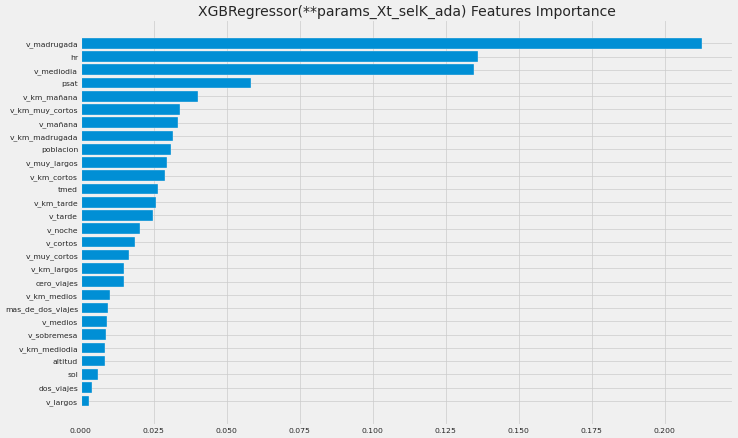

In [115]:
# plot
fig = plt.figure(figsize=(15, 10))
#plt.subplot(1, 2, 1)
#plt.barh(pos, importancias['best_grid_ada_rfa'][np.argsort(importancias['best_grid_ada_rfa'])], align='center')
plt.barh(pos, importancias['XGBRegressor(**params_Xt_selK_ada)'][sorted_imp], align='center')

plt.yticks((pos), np.array(atributos_selK_ada)[sorted_imp])
#np.array(features)[np.argsort(importancias['best_grid_ada_rfa'])])
plt.title('XGBRegressor(**params_Xt_selK_ada) Features Importance')
plt.show()

* IMPORTANCIAS-PERMUTATION 

In [116]:
perm_imp = permutation_importance(modelo_final, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=2)
sorted_idx = perm_imp.importances_mean.argsort()

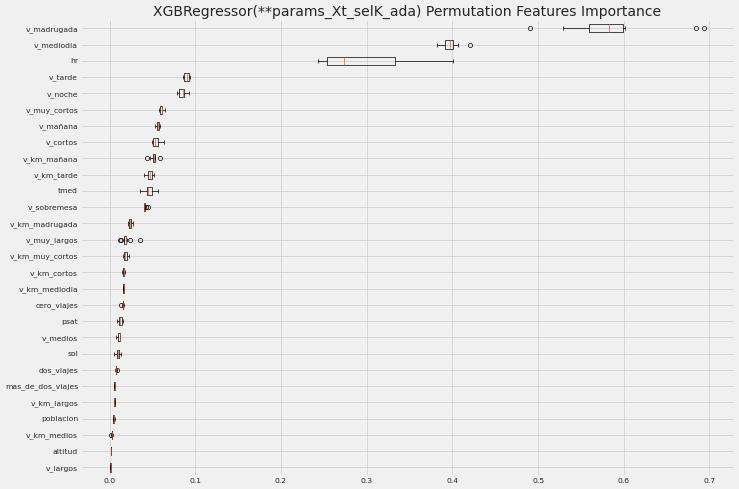

In [117]:
fig = plt.figure(figsize=(15, 10))

plt.boxplot(perm_imp.importances[sorted_idx].T, vert=False, labels=np.array(atributos_selK_ada)[sorted_idx])
plt.title("XGBRegressor(**params_Xt_selK_ada) Permutation Features Importance")
fig.tight_layout()
plt.show()

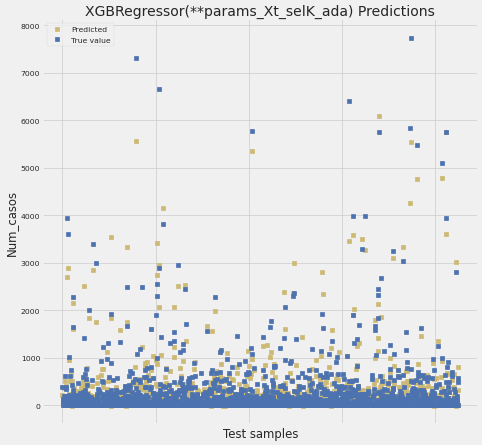

In [118]:
lista = [i for i in range(0,y_test.values.shape[0])]
xx = np.stack(lista)
plt.figure(figsize=(10,10))
plt.plot(xx, pred, "ys" ,label="Predicted")
plt.plot(xx, y_test, "bs" ,label="True value")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Num_casos")
plt.xlabel("Test samples")
plt.legend(loc="best")
plt.title("XGBRegressor(**params_Xt_selK_ada) Predictions")
plt.show()

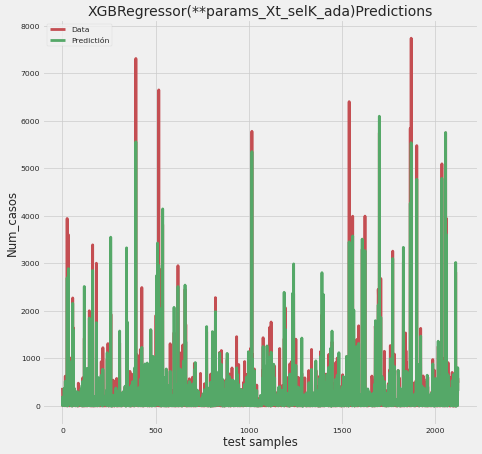

In [119]:
plt.figure(figsize=(10,10))
plt.plot(xx, y_test, c='r', label='Data')
#plt.plot(xx, y, c='k', label='data')
plt.ylabel("Num_casos")
plt.xlabel("test samples")
plt.plot(xx, pred, c='g', label='Predictión')
plt.axis('tight')
plt.legend()
plt.title("XGBRegressor(**params_Xt_selK_ada)Predictions")

plt.show()

In [ ]:
#best_grid_ada_rfa.get_params()

## Features  Interpretation 

Explainability :SHAP (SHapley Additive exPlanations)to understand what input features drive the prediction result.

In [120]:
import shap
shap.initjs()

In [123]:
print("Dimension :", Xt_selK_ada.shape)
#lista_Xt_kb_ada = select_kb_ada.get_support(indices= True)
#lista = Xt_selK_ada.columns
atributos_selK_ada = [lista_variables[int(x)] for x in lista_Xt_kb_ada] 
atributos_selK_ada

Dimension : (7077, 28)


['v_muy_cortos',
 'v_cortos',
 'v_medios',
 'v_largos',
 'v_muy_largos',
 'v_noche',
 'v_madrugada',
 'v_mañana',
 'v_mediodia',
 'v_sobremesa',
 'v_tarde',
 'v_km_muy_cortos',
 'v_km_cortos',
 'v_km_medios',
 'v_km_largos',
 'v_km_madrugada',
 'v_km_mañana',
 'v_km_mediodia',
 'v_km_tarde',
 'cero_viajes',
 'dos_viajes',
 'mas_de_dos_viajes',
 'altitud',
 'tmed',
 'sol',
 'psat',
 'hr',
 'poblacion']

In [128]:
X_selK_ada = pd.DataFrame(data=Xt_selK_ada, columns = atributos_selK_ada)

In [130]:
explainer = shap.TreeExplainer(modelo_final, X_test)
shap_values = explainer.shap_values(X_test)

100%|===================| 2116/2124 [00:48<00:00]        

In [134]:
#shap_values = shap.TreeExplainer(best_Grid_Xt_selK_ada).shap_values(X_test)
explainer = shap.TreeExplainer(modelo_final, X_test).shap_values(X_test)
#shap_values = explainer(X_test)
shap_interaction_values = shap.TreeExplainer(modelo_final).shap_interaction_values(X_test)

 99%|===================| 2104/2124 [01:06<00:00]        

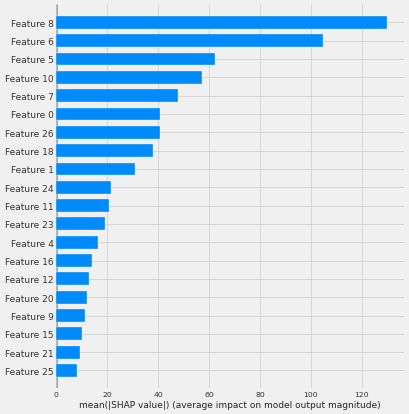

In [135]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
#shap.plots.bar(shap_values)

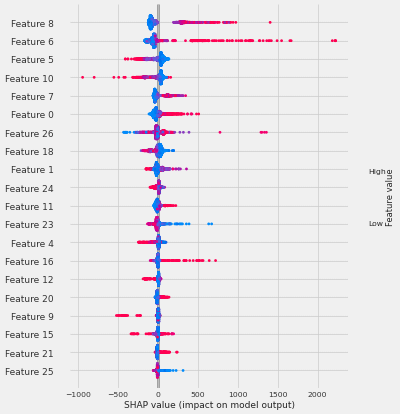

In [136]:
shap.summary_plot(shap_values, X_test)

In [ ]:
# shap.summary_plot(shap_values[:2000,:], X_test.iloc[:2000,:])

**Diferente? **

In [137]:
explainer = shap.TreeExplainer(modelo_final, X_test)
shap_values = explainer(X_test)

 98%|===================| 2088/2124 [00:54<00:00]        

In [ ]:
shap.plots.heatmap(shap_values, max_display=12)

In [ ]:
clust = shap.utils.hclust(Xt_selK_ada, labels, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [ ]:
shap.plots.scatter(shap_values, dot_size=2, x_jitter=0.5, color=shap_values,
ylabel="SHAP value\n(higher means more likely to renew)")

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values[23])

In [ ]:
shap.dependence_plot(hr, shap_values, X_test)

In [ ]:
print(" %.2f seconds for  hiperparameter settings."  % ((time.time() - clock_0)))

## Provincias

In [ ]:
clock_1 = time.time()

In [ ]:
def clima_provincia(row): # transfoma la provincia a mayusculas para unificar con otros ficheros
    if row.provincia in ['LA_CORUÑA', 'LUGO','ORENSE', 'PONTEVEDRA', 'HUELVA' ] :
        return "Atlantico"
    elif row.provincia in ['VALENCIA','ALICANTE','ALMERIA', 'CADIZ','GRANADA', 'MALAGA' ] :
        return "Mediterraneo"
    else:
        return "Continental"

In [ ]:
clima = tarjeta.apply(lambda row: clima_provincia(row), axis=1) 
tarjeta.insert(32,'clima', clima)# evolucion.head()

atlantico = tarjeta[tarjeta.clima == "Atlantico"].copy()
mediterraneo = tarjeta[tarjeta.clima == "Mediterraneo"].copy()
continental = tarjeta[tarjeta.clima == "Continental"].copy()

atlantico= atlantico.select_dtypes(exclude=['object'])
mediterraneo= mediterraneo.select_dtypes(exclude=['object'])
continental= continental.select_dtypes(exclude=['object'])

In [ ]:
X_atlantico = atlantico.drop(columns=['num_casos']).select_dtypes(exclude=['object'])
Y_atlantico = atlantico[['num_casos']]
features_a = X_atlantico.columns
labels_a = Y_atlantico.num_casos

X_norm_a = scaler.fit_transform(X_atlantico)

In [ ]:
X_mediterraneo = mediterraneo.drop(columns=['num_casos']).select_dtypes(exclude=['object'])
Y_mediterraneo = mediterraneo[['num_casos']]
features_m = X_mediterraneo.columns
labels_m = Y_mediterraneo.num_casos
    
X_norm_m = scaler.fit_transform(X_mediterraneo)

In [ ]:
X_continental = continental.drop(columns=['num_casos']).select_dtypes(exclude=['object'])
Y_continental = continental[['num_casos']]
features_c = X_continental.columns
labels_c = Y_continental.num_casos
    
X_norm_c = scaler.fit_transform(X_continental)

In [ ]:
def skb_regional(X_norm, labels, zona) :
    
    select = SelectKBest(score_func = mutual_info_regression, k='all')

    X_best_mi = select.fit_transform(X_norm, labels.num_casos) 
    
    X_train, X_test, y_train, y_test = train_test_split(X_best_mi, labels.num_casos, test_size = TEST_SIZE, random_state = RANDOM_STATE)
       
    gxb = GridSearchCV(xgb.XGBRegressor(random_state=RANDOM_STATE ), *param_grid, cv=kfcv,  
                       scoring = 'neg_mean_absolute_error',
                        verbose=1, refit = "mae", return_train_score=True, n_jobs=multiprocessing.cpu_count() // 2)
    
    gxb.fit(X_train, y_train)

    results = gxb.cv_results_
    print("best_score_ : ",gxb.best_score_)
    print("best_params_ : ",gxb.best_params_)
    # el mejor modelo
    mejor_modelo = gxb.best_estimator_

    # Entrenamiento del mejor modelo obtenido
    mejor_modelo.fit(X_train, y_train) 

    # nueva predicción 
    prediction = mejor_modelo.predict(X_test)
 
    eftEntrenamiento = mejor_modelo.score(X_train, y_train)
    eftPrediccion = mejor_modelo.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))

    mae = mean_absolute_error(y_test, prediction)
    
    media_casos_reales = np.mean(y_test)
    porcentaje = mae *100  / media_casos_reales
    print("MAE : ",mae, "porcentaje :", porcentaje, "tamaño :", X_best_mi.shape[1])

    return (['SKB-GridSearchCV', zona,'%.3f'%(porcentaje),'%.3f'%(X_best_mi.shape[1]), '%.3f'%(media_casos_reales), '%.3f'%(eftPrediccion),
             '%.3f'%(rmse), '%.3f'%(mae)])


In [ ]:
def dcf_regional(X_norm, labels, zona) :
    
    trh_dcf = DropCorrelatedFeatures(variables=None, method='spearman', threshold=0.957692) 

    X_t  = trh_dcf.fit_transform(X_norm, labels.num_casos)
    
    X_train, X_test, y_train, y_test = train_test_split(X_t , labels.num_casos, test_size = TEST_SIZE, random_state = RANDOM_STATE)
        
    gxb = GridSearchCV(xgb.XGBRegressor(random_state=RANDOM_STATE ), *param_grid, cv=kfcv,
                       scoring = 'neg_mean_absolute_error',
                        verbose=1, refit = "mae", return_train_score=True, n_jobs=multiprocessing.cpu_count() // 2)
    
    gxb.fit(X_train, y_train)

    results = gxb.cv_results_
    print("best_score_ : ",gxb.best_score_)
    print("best_params_ : ",gxb.best_params_)
    # el mejor modelo
    mejor_modelo = gxb.best_estimator_

    # Entrenamiento del mejor modelo obtenido
    mejor_modelo.fit(X_train, y_train) 

    # nueva predicción 
    prediction = mejor_modelo.predict(X_test)
 
    eftEntrenamiento = mejor_modelo.score(X_train, y_train)
    eftPrediccion = mejor_modelo.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))

    mae = mean_absolute_error(y_test, prediction)
    
    media_casos_reales = np.mean(y_test)
    porcentaje = mae *100  / media_casos_reales
    print("MAE : ",mae, "porcentaje :", porcentaje, "tamaño :", X_t.shape[1])

    return (['DCF-GridSearchCV', zona, '%.3f'%(porcentaje),'%.3f'%(X_t.shape[1]), '%.3f'%(media_casos_reales), '%.3f'%(eftPrediccion),
             '%.3f'%(rmse), '%.3f'%(mae)])


In [ ]:
def rfa_regional(X_norm, labels, zona) :
    
    trrec_ad = RecursiveFeatureAddition(estimator=xgb.XGBRegressor(random_state=RANDOM_STATE),  scoring="neg_mean_absolute_error", cv=kfcv)

    Xt_trrec_ad = trrec_ad.fit_transform(X_norm, labels.num_casos)
    
    X_train, X_test, y_train, y_test = train_test_split(Xt_trrec_ad, labels.num_casos, test_size = TEST_SIZE, random_state = RANDOM_STATE)

    gxb = GridSearchCV(xgb.XGBRegressor(random_state=RANDOM_STATE ), *param_grid, cv=kfcv,
                       scoring = 'neg_mean_absolute_error',
                       verbose=1, refit = "mae", return_train_score=True, n_jobs=multiprocessing.cpu_count() // 2)
   
    gxb.fit(X_train, y_train)

    results = gxb.cv_results_
    print("best_score_ : ",gxb.best_score_)
    print("best_params_ : ",gxb.best_params_)
    # el mejor modelo
    mejor_modelo = gxb.best_estimator_

    # Entrenamiento del mejor modelo obtenido
    mejor_modelo.fit(X_train, y_train) 

    # nueva predicción 
    prediction = mejor_modelo.predict(X_test)
 
    eftEntrenamiento = mejor_modelo.score(X_train, y_train)
    eftPrediccion = mejor_modelo.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))

    mae = mean_absolute_error(y_test, prediction)
    
    media_casos_reales = np.mean(y_test)
    porcentaje = mae *100  / media_casos_reales
    print("MAE : ",mae, "porcentaje :", porcentaje, "tamaño :", Xt_trrec_ad.shape[1])

    return (['RFA-GridSearchCV', zona, '%.3f'%(porcentaje),'%.3f'%(Xt_trrec_ad.shape[1]), '%.3f'%(media_casos_reales), '%.3f'%(eftPrediccion),
             '%.3f'%(rmse), '%.3f'%(mae)])


In [ ]:
def rfe_regional(X_norm, labels, zona) :
    
    trrec = RecursiveFeatureElimination(estimator=xgb.XGBRegressor(random_state=RANDOM_STATE), scoring="neg_mean_absolute_error", cv=kfcv)

    Xt_rfe = trrec.fit_transform(X_norm, labels.num_casos)
    
    X_train, X_test, y_train, y_test = train_test_split(Xt_rfe, labels.num_casos, test_size = TEST_SIZE, random_state = RANDOM_STATE)

    gxb = GridSearchCV(xgb.XGBRegressor(random_state=RANDOM_STATE ), *param_grid, cv=kfcv,
                       scoring = 'neg_mean_absolute_error',
                       verbose=1, refit = "mae", return_train_score=True, n_jobs=multiprocessing.cpu_count() // 2)
   
    gxb.fit(X_train, y_train)

    results = gxb.cv_results_
    print("best_score_ : ",gxb.best_score_)
    print("best_params_ : ",gxb.best_params_)
    # el mejor modelo
    mejor_modelo = gxb.best_estimator_

    # Entrenamiento del mejor modelo obtenido
    mejor_modelo.fit(X_train, y_train) 

    # nueva predicción 
    prediction = mejor_modelo.predict(X_test)
 
    eftEntrenamiento = mejor_modelo.score(X_train, y_train)
    eftPrediccion = mejor_modelo.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))

    mae = mean_absolute_error(y_test, prediction)
    
    media_casos_reales = np.mean(y_test)
    porcentaje = mae *100  / media_casos_reales
    print("MAE : ",mae, "porcentaje :", porcentaje, "tamaño :", Xt_rfe.shape[1])

    return (['RFE-GridSearchCV', zona, '%.3f'%(porcentaje),'%.3f'%(Xt_rfe.shape[1]), '%.3f'%(media_casos_reales), '%.3f'%(eftPrediccion),
             '%.3f'%(rmse), '%.3f'%(mae)])


### Climas

In [ ]:
modelado_reg = []

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm_a, labels_a, test_size = TEST_SIZE, random_state = RANDOM_STATE)

best_grid_ada_rfa.fit(X_train,y_train)
pred = best_grid_ada_rfa.predict(X_test)
    
eftEntrenamiento = best_grid_ada_rfa.score (X_train, y_train)
eftPrediccion = best_grid_ada_rfa.score (X_test, y_test)  
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

media_casos_reales = np.mean(y_test)
porcentaje = mae *100  / media_casos_reales

modelado_reg.append(['best_grid_ada_rfa', "Atlantico", '%.3f'%(porcentaje),'%.3f'%(X_continental.shape[1]), 
                     '%.3f'%(media_casos_reales), '%.3f'%(eftPrediccion),
                     '%.3f'%(rmse), '%.3f'%(mae)])


print([X_norm_a.shape[1], eftEntrenamiento, eftPrediccion, rmse, mae])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm_m, labels_m, test_size = TEST_SIZE, random_state = RANDOM_STATE)

best_grid_ada_rfa.fit(X_train,y_train)
pred = best_grid_ada_rfa.predict(X_test)
    
eftEntrenamiento = best_grid_ada_rfa.score (X_train, y_train)
eftPrediccion = best_grid_ada_rfa.score (X_test, y_test)  
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

media_casos_reales = np.mean(y_test)
porcentaje = mae *100  / media_casos_reales

modelado_reg.append(['best_grid_ada_rfa', "Mediterraneo", '%.3f'%(porcentaje),'%.3f'%(X_continental.shape[1]), 
                     '%.3f'%(media_casos_reales), '%.3f'%(eftPrediccion),
                     '%.3f'%(rmse), '%.3f'%(mae)])

print([X_norm_m.shape[1], eftEntrenamiento, eftPrediccion, rmse, mae])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm_c, labels_c, test_size = TEST_SIZE, random_state = RANDOM_STATE)

best_grid_ada_rfa.fit(X_train,y_train)
pred = best_grid_ada_rfa.predict(X_test)
    
eftEntrenamiento = best_grid_ada_rfa.score (X_train, y_train)
eftPrediccion = best_grid_ada_rfa.score (X_test, y_test)  
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

media_casos_reales = np.mean(y_test)
porcentaje = mae *100  / media_casos_reales

modelado_reg.append(['best_grid_ada_rfa', "Continental", '%.3f'%(porcentaje),'%.3f'%(X_continental.shape[1]), 
                     '%.3f'%(media_casos_reales), '%.3f'%(eftPrediccion),
                     '%.3f'%(rmse), '%.3f'%(mae)])

print([X_norm_c.shape[1], eftEntrenamiento, eftPrediccion, rmse, mae])

In [ ]:
modelado_reg.append(dcf_regional(X_atlantico, Y_atlantico, 'Atlantico'))
modelado_reg.append(rfa_regional(X_atlantico, Y_atlantico, 'Atlantico'))
modelado_reg.append(skb_regional(X_atlantico, Y_atlantico, 'Atlantico'))
modelado_reg.append(rfe_regional(X_atlantico, Y_atlantico, 'Atlantico'))

modelado_reg.append(dcf_regional(X_mediterraneo, Y_mediterraneo, 'Mediterraneo'))
modelado_reg.append(rfa_regional(X_mediterraneo, Y_mediterraneo, 'Mediterraneo'))
modelado_reg.append(skb_regional(X_mediterraneo, Y_mediterraneo, 'Mediterraneo'))
modelado_reg.append(rfe_regional(X_mediterraneo, Y_mediterraneo, 'Mediterraneo'))

modelado_reg.append(dcf_regional(X_continental, Y_continental, 'Continental'))
modelado_reg.append(rfa_regional(X_continental, Y_continental, 'Continental'))
modelado_reg.append(skb_regional(X_continental, Y_continental, 'Continental'))
modelado_reg.append(rfe_regional(X_continental, Y_continental, 'Continental'))

### Provincias

In [ ]:
for prov in tarjeta.provincia.unique().tolist():
    
    X_provs = tarjeta[tarjeta.provincia == prov].drop(columns=['num_casos']).select_dtypes(exclude=['object'])
    label_provs =tarjeta[tarjeta.provincia == prov][['num_casos']]
    X_train, X_test, y_train, y_test = train_test_split(X_provs, label_provs.num_casos, test_size = TEST_SIZE, random_state = RANDOM_STATE)
    
    best_grid_ada_rfa.fit(X_train,y_train)
    pred = best_grid_ada_rfa.predict(X_test)
    
    eftEntrenamiento = best_grid_ada_rfa.score (X_train, y_train)
    eftPrediccion = best_grid_ada_rfa.score (X_test, y_test)  
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    media_casos_reales = np.mean(y_test)
    porcentaje = mae * 100 / media_casos_reales

    modelado_reg.append(['best_grid_ada_rfa', prov, '%.3f'%(porcentaje),'%.3f'%(X_continental.shape[1]),
                         '%.3f'%(media_casos_reales), '%.3f'%(eftPrediccion), '%.3f'%(rmse), '%.3f'%(mae)])


In [ ]:
for prov in tarjeta.provincia.unique().tolist():
    X_provs = tarjeta[tarjeta.provincia == prov].drop(columns=['num_casos']).select_dtypes(exclude=['object'])
    label_provs =tarjeta[tarjeta.provincia == prov][['num_casos']]
    print ("Provincia : ", prov)
    modelado_reg.append(dcf_regional(X_provs, label_provs, prov ))
    modelado_reg.append(rfa_regional(X_provs, label_provs, prov ))
    modelado_reg.append(skb_regional(X_provs, label_provs, prov ))
    modelado_reg.append(rfe_regional(X_provs, label_provs, prov ))

    print ("-- --"*5)

## Resultados Climas y provincias

In [ ]:
modelado_reg

In [ ]:
metricas_modelos = pd.DataFrame(modelado_reg,
                                columns=['Método', 'Modelo', 'Prcnt', "#Feats", 'media_casos_reales', 'ScoreTest', 'RMSE',  'MAE'])
nombre = 'datos_regionales_hiperparametros_0.csv'

metricas_modelos.to_csv("~/Trabajo_tfm/datos_csv/modelos_" + nombre )

In [ ]:
metricas_modelos[:50]

In [ ]:
metricas_modelos[50:]

In [ ]:
print(" %.2f seconds for  provinces hiperparameter settings."  % ((time.time() - clock_1)))

In [ ]:
print(" %.2f seconds for  hiperparameter settings."  % ((time.time() - clock_0)))

In [ ]:
valores = metricas_modelos['MAE'].values
lista_variables = list(features)
lista = modelo_final.get_support()
[lista_variables[x] for x in lista]

pos = np.arange(np.argsort(metricas_modelos['MAE']).shape[0]) + .5
fig = plt.figure(figsize=(15,10))
#plt.subplot(1, 2, 1)
plt.barh(pos, metricas_modelos['MAE'][np.argsort(metricas_modelos['MAE'])], align='center')
plt.yticks(pos, np.array(features)[np.argsort(metricas_modelos['MAE'])])
plt.title('Importancia de los atributos para best_grid_ada_rfe')
plt.show()

In [ ]:

pos = np.arange(np.argsort(metricas_modelos['MAE']).shape[0]) + .5
fig = plt.figure(figsize=(15,10))
plt.barh(pos, metricas_modelos['MAE'][np.argsort(metricas_modelos['MAE'])], align='center')
plt.yticks(pos, np.array(features)[np.argsort(metricas_modelos['MAE'])])
plt.title('Valores de mae para climas y provincias')
plt.show()

